# Benchmark an Endpoint with Custom Data

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [5]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [6]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import jsonlines
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [7]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "src")
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "../")
from synthetic_performance_eval_script import *
from performance_evaluation import CustomPerformanceEvaluator
from benchmarking.utils import read_perf_eval_json_files

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [8]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

Benchmarking Endpoint: f6a70024-0b17-48d4-b6f8-2b04e174fb3f


#### Enter the endpoint API key

In [9]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [ ]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [ ]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [ ]:
env_tenant = "default"

In [ ]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [ ]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen-2.5-72B-SD-Qwen-2.5-0.5B',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [ ]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.3-70B-Instruct',
 'Qwen2.5-72B-Instruct',
 'Salesforce--Llama-xLAM-2-70b-fc-r',
 'Salesforce--Llama-xLAM-2-8b-fc-r']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [10]:
run_name = "salesforce_xlam2_70b_short_studio_mp1_sfdata_20250606_1"


#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [11]:
target_models = ['Salesforce--Llama-xLAM-2-70b-fc-r']

#### Read custom input file
Note that the file needs to be in jsonl format as shown in the example below. For image prompts, each line should contain a `prompt` key and an `image_path` key. The value of `image_path` should be the image encoded as text.

In [18]:
custom_input_path = os.path.expanduser("~/Downloads/custom_prompt_data.jsonl")
prompts = []
with open(custom_input_path, "r") as f:
    for line in f:
        prompts.append(line.strip())
prompts = list(set(prompts))[:5]
prompts[0]

'{"prompt": "Rewrite the context section word by word then answer the question: Where was the wife of Francis I Rákóczi born?\\n\\nContext: Passage 1:\\nWaldrada of Lotharingia\\nWaldrada was the mistress, and later the wife, of Lothair IIof Lotharingia.\\n\\nBiography\\nWaldrada\'s family origin is uncertain. The prolific 19th-century French writer Baron Ernouf suggested that Waldrada was of noble Gallo-Roman descent, sister of Thietgaud, the bishop of Trier, and niece of Gunther, archbishop of Cologne. However, these suggestions are not supported by any evidence, and more recent studies have instead suggested she was of relatively undistinguished social origins, though still from an aristocratic milieu.\\nThe Vita Sancti Deicoli statesthat Waldrada was related to Eberhard II, Count of Nordgau (included Strasbourg) and the family of Etichonids, though this is a late 10th-century source and so may not be entirely reliable on this question.In 855 the Carolingian king Lothar II marriedTe

#### Specify configs for benchmarking

In [19]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"

config = {
    'sampling_params': {'max_tokens_to_generate': 1000},    
    'output_files_dir': os.path.join(f'{output_path}logs/output_files/', run_name), # each run saved here
    'consolidated_results_dir': os.path.join(f'{output_path}consolidated_results', run_name), # consolidated xlsx saved here
    'timeout': 3600,
    'num_requests': 64,
    'concurrent_requests': [1, 2, 4, 8, 16, 32],
    'save_response_texts': False,
    'llm_api': 'sambastudio'
}

## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Benchmarking produces json files with detailed results for each configuration

In [20]:
for target_model in target_models:
    for num_concurrent_requests in config['concurrent_requests']:        
        for i, prompt in enumerate(prompts):
            # Create file with output
            os.makedirs(config['output_files_dir'], exist_ok=True)
            prompt_file_path = os.path.join(config['output_files_dir'], f"custom_prompt_{i}.jsonl")
            
            with jsonlines.open(prompt_file_path, "w") as writer:
                for j in range(config['num_requests']):
                    writer.write(json.loads(prompt))

            custom_evaluator = CustomPerformanceEvaluator(
                model_name=target_model,        
                results_dir=config['output_files_dir'],
                num_concurrent_requests=num_concurrent_requests,
                timeout=config["timeout"],
                user_metadata={"model_idx": 0},
                input_file_path=prompt_file_path,
                save_response_texts=config['save_response_texts'],
                llm_api=config['llm_api'],
            )
            # Run performance evaluation
            custom_evaluator.run_benchmark(sampling_params=config['sampling_params'])

Running Requests: 100%|██████████| 64/64 [01:29<00:00,  1.37s/it]

2025-06-06 16:20:47,005 [INFO] Tasks Executed!
2025-06-06 16:20:47,006 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:20:47,028 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:20:47,033 [INFO]     p5 = 1.071
2025-06-06 16:20:47,033 [INFO]     p25 = 1.0986
2025-06-06 16:20:47,034 [INFO]     p50 = 1.2053
2025-06-06 16:20:47,034 [INFO]     p75 = 1.3012
2025-06-06 16:20:47,035 [INFO]     p90 = 1.3879
2025-06-06 16:20:47,035 [INFO]     p95 = 1.4127
2025-06-06 16:20:47,036 [INFO]     p99 = 2.4791
2025-06-06 16:20:47,039 [INFO]     mean = 1.2603
2025-06-06 16:20:47,039 [INFO]     min = 1.0623
2025-06-06 16:20:47,040 [INFO]     max = 3.913
2025-06-06 16:20:47,040 [INFO]     stddev = 0.3582
2025-06-06 16:20:47,040 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:20:47,042 [INFO]     p5 = 1.2138
2025-06-06 16:20:47,042 [INFO]     p25 = 1.236

Running Requests: 100%|██████████| 64/64 [01:14<00:00,  1.04s/it]

2025-06-06 16:22:01,445 [INFO] Tasks Executed!
2025-06-06 16:22:01,446 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:22:01,451 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:22:01,453 [INFO]     p5 = 0.5237
2025-06-06 16:22:01,454 [INFO]     p25 = 0.5517
2025-06-06 16:22:01,455 [INFO]     p50 = 0.683
2025-06-06 16:22:01,455 [INFO]     p75 = 0.7687
2025-06-06 16:22:01,456 [INFO]     p90 = 0.8019
2025-06-06 16:22:01,457 [INFO]     p95 = 0.8414
2025-06-06 16:22:01,457 [INFO]     p99 = 1.0293
2025-06-06 16:22:01,459 [INFO]     mean = 0.6734
2025-06-06 16:22:01,459 [INFO]     min = 0.5196
2025-06-06 16:22:01,460 [INFO]     max = 1.1253
2025-06-06 16:22:01,466 [INFO]     stddev = 0.127
2025-06-06 16:22:01,470 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:22:01,473 [INFO]     p5 = 1.0111
2025-06-06 16:22:01,475 [INFO]     p25 = 1.024

Running Requests: 100%|██████████| 64/64 [01:50<00:00,  1.71s/it]

2025-06-06 16:23:52,036 [INFO] Tasks Executed!
2025-06-06 16:23:52,037 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:23:52,041 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:23:52,044 [INFO]     p5 = 0.3436
2025-06-06 16:23:52,044 [INFO]     p25 = 0.3949
2025-06-06 16:23:52,044 [INFO]     p50 = 0.5153
2025-06-06 16:23:52,045 [INFO]     p75 = 0.5983
2025-06-06 16:23:52,046 [INFO]     p90 = 0.6475
2025-06-06 16:23:52,046 [INFO]     p95 = 0.6586
2025-06-06 16:23:52,047 [INFO]     p99 = 0.6703
2025-06-06 16:23:52,048 [INFO]     mean = 0.5081
2025-06-06 16:23:52,048 [INFO]     min = 0.3201
2025-06-06 16:23:52,049 [INFO]     max = 0.6722
2025-06-06 16:23:52,050 [INFO]     stddev = 0.1109
2025-06-06 16:23:52,050 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:23:52,052 [INFO]     p5 = 1.5673
2025-06-06 16:23:52,052 [INFO]     p25 = 1.6

Running Requests: 100%|██████████| 64/64 [00:58<00:00,  1.11it/s]

2025-06-06 16:24:50,779 [INFO] Tasks Executed!
2025-06-06 16:24:50,780 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:24:50,785 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:24:50,788 [INFO]     p5 = 0.5664
2025-06-06 16:24:50,789 [INFO]     p25 = 0.6819
2025-06-06 16:24:50,789 [INFO]     p50 = 0.739
2025-06-06 16:24:50,790 [INFO]     p75 = 0.7835
2025-06-06 16:24:50,790 [INFO]     p90 = 0.8117
2025-06-06 16:24:50,791 [INFO]     p95 = 0.8482
2025-06-06 16:24:50,791 [INFO]     p99 = 0.8799
2025-06-06 16:24:50,792 [INFO]     mean = 0.7273
2025-06-06 16:24:50,793 [INFO]     min = 0.5404
2025-06-06 16:24:50,794 [INFO]     max = 0.8808
2025-06-06 16:24:50,794 [INFO]     stddev = 0.0823
2025-06-06 16:24:50,795 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:24:50,796 [INFO]     p5 = 0.7636
2025-06-06 16:24:50,797 [INFO]     p25 = 0.83

Running Requests: 100%|██████████| 64/64 [00:45<00:00,  1.35it/s]

2025-06-06 16:25:37,085 [INFO] Tasks Executed!
2025-06-06 16:25:37,087 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:25:37,093 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:25:37,095 [INFO]     p5 = 0.3601
2025-06-06 16:25:37,096 [INFO]     p25 = 0.4407
2025-06-06 16:25:37,097 [INFO]     p50 = 0.5145
2025-06-06 16:25:37,097 [INFO]     p75 = 0.595
2025-06-06 16:25:37,098 [INFO]     p90 = 0.6323
2025-06-06 16:25:37,098 [INFO]     p95 = 0.6482
2025-06-06 16:25:37,099 [INFO]     p99 = 0.6875
2025-06-06 16:25:37,100 [INFO]     mean = 0.5107
2025-06-06 16:25:37,101 [INFO]     min = 0.3328
2025-06-06 16:25:37,101 [INFO]     max = 0.7018
2025-06-06 16:25:37,102 [INFO]     stddev = 0.0981
2025-06-06 16:25:37,103 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:25:37,105 [INFO]     p5 = 0.5838
2025-06-06 16:25:37,106 [INFO]     p25 = 0.62

Running Requests: 100%|██████████| 64/64 [01:10<00:00,  1.08s/it]

2025-06-06 16:26:47,726 [INFO] Tasks Executed!
2025-06-06 16:26:47,726 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:26:47,728 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:26:47,729 [INFO]     p5 = 2.0158
2025-06-06 16:26:47,729 [INFO]     p25 = 2.0226
2025-06-06 16:26:47,730 [INFO]     p50 = 2.0324
2025-06-06 16:26:47,730 [INFO]     p75 = 2.0422
2025-06-06 16:26:47,730 [INFO]     p90 = 2.1197
2025-06-06 16:26:47,730 [INFO]     p95 = 2.1308
2025-06-06 16:26:47,730 [INFO]     p99 = 2.1718
2025-06-06 16:26:47,731 [INFO]     mean = 2.0312
2025-06-06 16:26:47,731 [INFO]     min = 1.0939
2025-06-06 16:26:47,731 [INFO]     max = 2.2259
2025-06-06 16:26:47,732 [INFO]     stddev = 0.1257
2025-06-06 16:26:47,732 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:26:47,735 [INFO]     p5 = 2.1539
2025-06-06 16:26:47,736 [INFO]     p25 = 2.1

Running Requests: 100%|██████████| 64/64 [00:57<00:00,  1.12it/s]

2025-06-06 16:27:45,801 [INFO] Tasks Executed!
2025-06-06 16:27:45,802 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:27:45,805 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:27:45,808 [INFO]     p5 = 1.2909
2025-06-06 16:27:45,808 [INFO]     p25 = 1.2961
2025-06-06 16:27:45,809 [INFO]     p50 = 1.2995
2025-06-06 16:27:45,809 [INFO]     p75 = 1.3035
2025-06-06 16:27:45,810 [INFO]     p90 = 1.3076
2025-06-06 16:27:45,810 [INFO]     p95 = 1.3445
2025-06-06 16:27:45,810 [INFO]     p99 = 1.3836
2025-06-06 16:27:45,811 [INFO]     mean = 1.292
2025-06-06 16:27:45,812 [INFO]     min = 0.5282
2025-06-06 16:27:45,812 [INFO]     max = 1.4231
2025-06-06 16:27:45,813 [INFO]     stddev = 0.099
2025-06-06 16:27:45,813 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:27:45,815 [INFO]     p5 = 1.7779
2025-06-06 16:27:45,815 [INFO]     p25 = 1.784

Running Requests: 100%|██████████| 64/64 [01:32<00:00,  1.43s/it]

2025-06-06 16:29:18,451 [INFO] Tasks Executed!
2025-06-06 16:29:18,452 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:29:18,455 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:29:18,458 [INFO]     p5 = 1.6467
2025-06-06 16:29:18,458 [INFO]     p25 = 1.6536
2025-06-06 16:29:18,459 [INFO]     p50 = 1.6574
2025-06-06 16:29:18,460 [INFO]     p75 = 1.6635
2025-06-06 16:29:18,460 [INFO]     p90 = 1.6684
2025-06-06 16:29:18,460 [INFO]     p95 = 1.6726
2025-06-06 16:29:18,461 [INFO]     p99 = 1.7248
2025-06-06 16:29:18,462 [INFO]     mean = 1.6405
2025-06-06 16:29:18,462 [INFO]     min = 0.3603
2025-06-06 16:29:18,463 [INFO]     max = 1.8015
2025-06-06 16:29:18,464 [INFO]     stddev = 0.1637
2025-06-06 16:29:18,464 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:29:18,466 [INFO]     p5 = 2.8538
2025-06-06 16:29:18,467 [INFO]     p25 = 2.8

Running Requests: 100%|██████████| 64/64 [00:39<00:00,  1.66it/s]

2025-06-06 16:29:57,798 [INFO] Tasks Executed!
2025-06-06 16:29:57,799 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:29:57,803 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:29:57,805 [INFO]     p5 = 0.9974
2025-06-06 16:29:57,806 [INFO]     p25 = 1.0013
2025-06-06 16:29:57,807 [INFO]     p50 = 1.0066
2025-06-06 16:29:57,808 [INFO]     p75 = 1.0104
2025-06-06 16:29:57,809 [INFO]     p90 = 1.0152
2025-06-06 16:29:57,809 [INFO]     p95 = 1.0165
2025-06-06 16:29:57,810 [INFO]     p99 = 1.0648
2025-06-06 16:29:57,813 [INFO]     mean = 1.0012
2025-06-06 16:29:57,813 [INFO]     min = 0.5418
2025-06-06 16:29:57,814 [INFO]     max = 1.1402
2025-06-06 16:29:57,814 [INFO]     stddev = 0.061
2025-06-06 16:29:57,815 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:29:57,818 [INFO]     p5 = 1.1916
2025-06-06 16:29:57,819 [INFO]     p25 = 1.19

Running Requests: 100%|██████████| 64/64 [00:32<00:00,  2.23it/s]

2025-06-06 16:30:31,049 [INFO] Tasks Executed!
2025-06-06 16:30:31,051 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:30:31,057 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:30:31,061 [INFO]     p5 = 0.6636
2025-06-06 16:30:31,062 [INFO]     p25 = 0.6702
2025-06-06 16:30:31,062 [INFO]     p50 = 0.6727
2025-06-06 16:30:31,063 [INFO]     p75 = 0.6757
2025-06-06 16:30:31,064 [INFO]     p90 = 0.6786
2025-06-06 16:30:31,065 [INFO]     p95 = 0.6812
2025-06-06 16:30:31,065 [INFO]     p99 = 4.7523
2025-06-06 16:30:31,066 [INFO]     mean = 0.7903
2025-06-06 16:30:31,067 [INFO]     min = 0.3447
2025-06-06 16:30:31,068 [INFO]     max = 4.7529
2025-06-06 16:30:31,068 [INFO]     stddev = 0.7196
2025-06-06 16:30:31,068 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:30:31,071 [INFO]     p5 = 0.8846
2025-06-06 16:30:31,072 [INFO]     p25 = 0.8

Running Requests:  97%|█████████▋| 62/64 [01:24<00:03,  1.99s/it]

2025-06-06 16:31:56,111 [INFO] Tasks Executed!
2025-06-06 16:31:56,113 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:31:56,123 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:31:56,128 [INFO]     p5 = 4.8435
2025-06-06 16:31:56,129 [INFO]     p25 = 4.8499
2025-06-06 16:31:56,130 [INFO]     p50 = 4.856
2025-06-06 16:31:56,130 [INFO]     p75 = 4.8816
2025-06-06 16:31:56,131 [INFO]     p90 = 4.8949
2025-06-06 16:31:56,131 [INFO]     p95 = 7.8845
2025-06-06 16:31:56,131 [INFO]     p99 = 8.4659
2025-06-06 16:31:56,133 [INFO]     mean = 5.0278
2025-06-06 16:31:56,133 [INFO]     min = 1.0836
2025-06-06 16:31:56,134 [INFO]     max = 8.4667
2025-06-06 16:31:56,134 [INFO]     stddev = 1.0087
2025-06-06 16:31:56,135 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:31:56,137 [INFO]     p5 = 5.0057
2025-06-06 16:31:56,138 [INFO]     p25 = 5.01

Running Requests: 100%|██████████| 64/64 [00:44<00:00,  1.20it/s]

2025-06-06 16:32:40,974 [INFO] Tasks Executed!
2025-06-06 16:32:40,974 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:32:40,977 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:32:40,979 [INFO]     p5 = 2.1572
2025-06-06 16:32:40,980 [INFO]     p25 = 2.1635
2025-06-06 16:32:40,980 [INFO]     p50 = 2.1712
2025-06-06 16:32:40,981 [INFO]     p75 = 2.2447
2025-06-06 16:32:40,981 [INFO]     p90 = 2.261
2025-06-06 16:32:40,982 [INFO]     p95 = 2.3553
2025-06-06 16:32:40,982 [INFO]     p99 = 2.403
2025-06-06 16:32:40,983 [INFO]     mean = 2.1776
2025-06-06 16:32:40,983 [INFO]     min = 0.5236
2025-06-06 16:32:40,984 [INFO]     max = 2.4039
2025-06-06 16:32:40,984 [INFO]     stddev = 0.2191
2025-06-06 16:32:40,985 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:32:40,987 [INFO]     p5 = 2.7268
2025-06-06 16:32:40,987 [INFO]     p25 = 2.735

Running Requests: 100%|██████████| 64/64 [01:00<00:00,  1.07it/s]

2025-06-06 16:33:41,463 [INFO] Tasks Executed!
2025-06-06 16:33:41,464 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:33:41,467 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:33:41,469 [INFO]     p5 = 2.0337
2025-06-06 16:33:41,470 [INFO]     p25 = 2.0433
2025-06-06 16:33:41,470 [INFO]     p50 = 2.0607
2025-06-06 16:33:41,470 [INFO]     p75 = 2.2039
2025-06-06 16:33:41,471 [INFO]     p90 = 2.2346
2025-06-06 16:33:41,471 [INFO]     p95 = 6.1369
2025-06-06 16:33:41,472 [INFO]     p99 = 6.841
2025-06-06 16:33:41,473 [INFO]     mean = 2.3656
2025-06-06 16:33:41,473 [INFO]     min = 0.3353
2025-06-06 16:33:41,473 [INFO]     max = 6.8662
2025-06-06 16:33:41,474 [INFO]     stddev = 1.186
2025-06-06 16:33:41,475 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:33:41,477 [INFO]     p5 = 3.4099
2025-06-06 16:33:41,478 [INFO]     p25 = 3.413

Running Requests:  97%|█████████▋| 62/64 [00:34<00:01,  1.21it/s]

2025-06-06 16:34:16,469 [INFO] Tasks Executed!
2025-06-06 16:34:16,470 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:34:16,473 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:34:16,475 [INFO]     p5 = 1.7606
2025-06-06 16:34:16,475 [INFO]     p25 = 1.8705
2025-06-06 16:34:16,476 [INFO]     p50 = 1.8776
2025-06-06 16:34:16,476 [INFO]     p75 = 1.912
2025-06-06 16:34:16,476 [INFO]     p90 = 1.9676
2025-06-06 16:34:16,477 [INFO]     p95 = 2.0088
2025-06-06 16:34:16,478 [INFO]     p99 = 2.0173
2025-06-06 16:34:16,479 [INFO]     mean = 1.8667
2025-06-06 16:34:16,479 [INFO]     min = 0.5476
2025-06-06 16:34:16,480 [INFO]     max = 2.0218
2025-06-06 16:34:16,480 [INFO]     stddev = 0.1772
2025-06-06 16:34:16,480 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:34:16,482 [INFO]     p5 = 1.9838
2025-06-06 16:34:16,482 [INFO]     p25 = 2.10

Running Requests:  97%|█████████▋| 62/64 [00:21<00:01,  1.80it/s]

2025-06-06 16:34:38,101 [INFO] Tasks Executed!
2025-06-06 16:34:38,102 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:34:38,106 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:34:38,110 [INFO]     p5 = 1.0459
2025-06-06 16:34:38,111 [INFO]     p25 = 1.0533
2025-06-06 16:34:38,111 [INFO]     p50 = 1.0587
2025-06-06 16:34:38,111 [INFO]     p75 = 1.0871
2025-06-06 16:34:38,112 [INFO]     p90 = 1.1454
2025-06-06 16:34:38,112 [INFO]     p95 = 1.1649
2025-06-06 16:34:38,112 [INFO]     p99 = 1.3224
2025-06-06 16:34:38,113 [INFO]     mean = 1.0631
2025-06-06 16:34:38,113 [INFO]     min = 0.3284
2025-06-06 16:34:38,113 [INFO]     max = 1.5855
2025-06-06 16:34:38,114 [INFO]     stddev = 0.1305
2025-06-06 16:34:38,114 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:34:38,115 [INFO]     p5 = 1.2443
2025-06-06 16:34:38,115 [INFO]     p25 = 1.3

Running Requests:  91%|█████████ | 58/64 [01:13<00:11,  1.99s/it]

2025-06-06 16:35:51,553 [INFO] Tasks Executed!
2025-06-06 16:35:51,555 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:35:51,560 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:35:51,563 [INFO]     p5 = 8.3951
2025-06-06 16:35:51,564 [INFO]     p25 = 8.453
2025-06-06 16:35:51,565 [INFO]     p50 = 8.4564
2025-06-06 16:35:51,566 [INFO]     p75 = 8.4679
2025-06-06 16:35:51,567 [INFO]     p90 = 11.6071
2025-06-06 16:35:51,568 [INFO]     p95 = 11.6276
2025-06-06 16:35:51,568 [INFO]     p99 = 11.6285
2025-06-06 16:35:51,570 [INFO]     mean = 8.7366
2025-06-06 16:35:51,570 [INFO]     min = 1.1077
2025-06-06 16:35:51,570 [INFO]     max = 11.6298
2025-06-06 16:35:51,571 [INFO]     stddev = 1.4313
2025-06-06 16:35:51,571 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:35:51,573 [INFO]     p5 = 8.5992
2025-06-06 16:35:51,573 [INFO]     p25 = 

Running Requests: 100%|██████████| 64/64 [00:33<00:00,  1.08s/it]

2025-06-06 16:36:25,009 [INFO] Tasks Executed!
2025-06-06 16:36:25,010 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:36:25,015 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:36:25,018 [INFO]     p5 = 3.3461
2025-06-06 16:36:25,018 [INFO]     p25 = 3.354
2025-06-06 16:36:25,020 [INFO]     p50 = 3.3625
2025-06-06 16:36:25,021 [INFO]     p75 = 3.3856
2025-06-06 16:36:25,021 [INFO]     p90 = 3.7182
2025-06-06 16:36:25,025 [INFO]     p95 = 3.7364
2025-06-06 16:36:25,032 [INFO]     p99 = 3.7392
2025-06-06 16:36:25,034 [INFO]     mean = 3.3845
2025-06-06 16:36:25,037 [INFO]     min = 0.6633
2025-06-06 16:36:25,038 [INFO]     max = 3.7398
2025-06-06 16:36:25,040 [INFO]     stddev = 0.3694
2025-06-06 16:36:25,040 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:36:25,046 [INFO]     p5 = 4.0422
2025-06-06 16:36:25,047 [INFO]     p25 = 4.05

Running Requests: 100%|██████████| 64/64 [00:37<00:00,  1.43it/s]

2025-06-06 16:37:03,254 [INFO] Tasks Executed!
2025-06-06 16:37:03,254 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:37:03,257 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:37:03,259 [INFO]     p5 = 2.5882
2025-06-06 16:37:03,260 [INFO]     p25 = 2.5957
2025-06-06 16:37:03,260 [INFO]     p50 = 2.5995
2025-06-06 16:37:03,260 [INFO]     p75 = 2.6327
2025-06-06 16:37:03,261 [INFO]     p90 = 6.83
2025-06-06 16:37:03,261 [INFO]     p95 = 6.8318
2025-06-06 16:37:03,262 [INFO]     p99 = 6.9294
2025-06-06 16:37:03,263 [INFO]     mean = 3.1294
2025-06-06 16:37:03,264 [INFO]     min = 0.3324
2025-06-06 16:37:03,274 [INFO]     max = 7.0949
2025-06-06 16:37:03,275 [INFO]     stddev = 1.4551
2025-06-06 16:37:03,276 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:37:03,280 [INFO]     p5 = 4.1347
2025-06-06 16:37:03,283 [INFO]     p25 = 4.146

Running Requests: 100%|██████████| 64/64 [00:27<00:00,  1.07s/it]

2025-06-06 16:37:30,925 [INFO] Tasks Executed!
2025-06-06 16:37:30,925 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:37:30,929 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:37:30,931 [INFO]     p5 = 3.0546
2025-06-06 16:37:30,931 [INFO]     p25 = 3.0616
2025-06-06 16:37:30,932 [INFO]     p50 = 3.0686
2025-06-06 16:37:30,933 [INFO]     p75 = 3.0776
2025-06-06 16:37:30,933 [INFO]     p90 = 3.2159
2025-06-06 16:37:30,934 [INFO]     p95 = 3.2183
2025-06-06 16:37:30,934 [INFO]     p99 = 3.2351
2025-06-06 16:37:30,935 [INFO]     mean = 3.0547
2025-06-06 16:37:30,937 [INFO]     min = 0.5383
2025-06-06 16:37:30,937 [INFO]     max = 3.2567
2025-06-06 16:37:30,938 [INFO]     stddev = 0.3245
2025-06-06 16:37:30,938 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:37:30,940 [INFO]     p5 = 3.3412
2025-06-06 16:37:30,941 [INFO]     p25 = 3.3

Running Requests: 100%|██████████| 64/64 [00:16<00:00,  2.55it/s]

2025-06-06 16:37:47,774 [INFO] Tasks Executed!
2025-06-06 16:37:47,774 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:37:47,778 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:37:47,780 [INFO]     p5 = 1.7069
2025-06-06 16:37:47,781 [INFO]     p25 = 1.7189
2025-06-06 16:37:47,782 [INFO]     p50 = 1.7266
2025-06-06 16:37:47,783 [INFO]     p75 = 1.7679
2025-06-06 16:37:47,784 [INFO]     p90 = 1.7822
2025-06-06 16:37:47,785 [INFO]     p95 = 1.8592
2025-06-06 16:37:47,790 [INFO]     p99 = 1.8595
2025-06-06 16:37:47,795 [INFO]     mean = 1.7073
2025-06-06 16:37:47,797 [INFO]     min = 0.4736
2025-06-06 16:37:47,799 [INFO]     max = 1.8597
2025-06-06 16:37:47,800 [INFO]     stddev = 0.227
2025-06-06 16:37:47,801 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:37:47,805 [INFO]     p5 = 1.9939
2025-06-06 16:37:47,808 [INFO]     p25 = 2.00

Running Requests: 100%|██████████| 64/64 [01:09<00:00,  4.28s/it]

2025-06-06 16:38:57,458 [INFO] Tasks Executed!
2025-06-06 16:38:57,459 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:38:57,467 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:38:57,470 [INFO]     p5 = 15.5867
2025-06-06 16:38:57,470 [INFO]     p25 = 15.713
2025-06-06 16:38:57,471 [INFO]     p50 = 15.8133
2025-06-06 16:38:57,471 [INFO]     p75 = 16.9399
2025-06-06 16:38:57,471 [INFO]     p90 = 20.1371
2025-06-06 16:38:57,472 [INFO]     p95 = 20.1387
2025-06-06 16:38:57,472 [INFO]     p99 = 20.1497
2025-06-06 16:38:57,474 [INFO]     mean = 16.6175
2025-06-06 16:38:57,474 [INFO]     min = 1.1213
2025-06-06 16:38:57,474 [INFO]     max = 20.158
2025-06-06 16:38:57,475 [INFO]     stddev = 2.743
2025-06-06 16:38:57,475 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:38:57,477 [INFO]     p5 = 15.8769
2025-06-06 16:38:57,477 [INFO]     p2

Running Requests:  91%|█████████ | 58/64 [00:27<00:07,  1.27s/it]

2025-06-06 16:39:25,277 [INFO] Tasks Executed!
2025-06-06 16:39:25,278 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:39:25,281 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:39:25,284 [INFO]     p5 = 5.66
2025-06-06 16:39:25,284 [INFO]     p25 = 5.6758
2025-06-06 16:39:25,285 [INFO]     p50 = 5.7448
2025-06-06 16:39:25,285 [INFO]     p75 = 5.9228
2025-06-06 16:39:25,286 [INFO]     p90 = 5.93
2025-06-06 16:39:25,286 [INFO]     p95 = 5.9349
2025-06-06 16:39:25,286 [INFO]     p99 = 6.2123
2025-06-06 16:39:25,288 [INFO]     mean = 5.6976
2025-06-06 16:39:25,288 [INFO]     min = 0.5463
2025-06-06 16:39:25,288 [INFO]     max = 6.291
2025-06-06 16:39:25,289 [INFO]     stddev = 0.6689
2025-06-06 16:39:25,289 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:39:25,291 [INFO]     p5 = 6.6129
2025-06-06 16:39:25,291 [INFO]     p25 = 6.6347
2

Running Requests:  92%|█████████▏| 59/64 [00:27<00:04,  1.13it/s]

2025-06-06 16:39:52,928 [INFO] Tasks Executed!
2025-06-06 16:39:52,929 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:39:52,932 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:39:52,934 [INFO]     p5 = 3.6176
2025-06-06 16:39:52,935 [INFO]     p25 = 3.6693
2025-06-06 16:39:52,935 [INFO]     p50 = 3.6812
2025-06-06 16:39:52,936 [INFO]     p75 = 5.3833
2025-06-06 16:39:52,936 [INFO]     p90 = 8.4009
2025-06-06 16:39:52,937 [INFO]     p95 = 8.4024
2025-06-06 16:39:52,937 [INFO]     p99 = 8.6191
2025-06-06 16:39:52,938 [INFO]     mean = 4.8309
2025-06-06 16:39:52,939 [INFO]     min = 0.364
2025-06-06 16:39:52,939 [INFO]     max = 8.9832
2025-06-06 16:39:52,940 [INFO]     stddev = 2.1438
2025-06-06 16:39:52,940 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:39:52,942 [INFO]     p5 = 5.5241
2025-06-06 16:39:52,942 [INFO]     p25 = 5.56

Running Requests: 100%|██████████| 64/64 [00:24<00:00,  1.58s/it]

2025-06-06 16:40:17,718 [INFO] Tasks Executed!
2025-06-06 16:40:17,720 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:40:17,729 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:40:17,732 [INFO]     p5 = 5.3602
2025-06-06 16:40:17,733 [INFO]     p25 = 5.3771
2025-06-06 16:40:17,734 [INFO]     p50 = 5.4913
2025-06-06 16:40:17,735 [INFO]     p75 = 5.5108
2025-06-06 16:40:17,736 [INFO]     p90 = 5.5133
2025-06-06 16:40:17,736 [INFO]     p95 = 5.5797
2025-06-06 16:40:17,737 [INFO]     p99 = 5.8391
2025-06-06 16:40:17,738 [INFO]     mean = 5.3846
2025-06-06 16:40:17,739 [INFO]     min = 0.5262
2025-06-06 16:40:17,739 [INFO]     max = 6.1888
2025-06-06 16:40:17,740 [INFO]     stddev = 0.6281
2025-06-06 16:40:17,740 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:40:17,742 [INFO]     p5 = 5.766
2025-06-06 16:40:17,742 [INFO]     p25 = 5.77

Running Requests: 100%|██████████| 64/64 [00:13<00:00,  1.54it/s]

2025-06-06 16:40:32,017 [INFO] Tasks Executed!
2025-06-06 16:40:32,018 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:40:32,023 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:40:32,027 [INFO]     p5 = 2.6595
2025-06-06 16:40:32,028 [INFO]     p25 = 2.822
2025-06-06 16:40:32,028 [INFO]     p50 = 3.0092
2025-06-06 16:40:32,029 [INFO]     p75 = 3.1
2025-06-06 16:40:32,030 [INFO]     p90 = 3.1117
2025-06-06 16:40:32,030 [INFO]     p95 = 3.2155
2025-06-06 16:40:32,031 [INFO]     p99 = 3.6132
2025-06-06 16:40:32,032 [INFO]     mean = 2.9175
2025-06-06 16:40:32,033 [INFO]     min = 0.3516
2025-06-06 16:40:32,033 [INFO]     max = 3.615
2025-06-06 16:40:32,034 [INFO]     stddev = 0.3925
2025-06-06 16:40:32,035 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:40:32,037 [INFO]     p5 = 3.0055
2025-06-06 16:40:32,038 [INFO]     p25 = 3.1614
2

Running Requests: 100%|██████████| 64/64 [01:01<00:00,  4.42s/it]

2025-06-06 16:41:34,045 [INFO] Tasks Executed!
2025-06-06 16:41:34,046 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:41:34,049 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:41:34,051 [INFO]     p5 = 15.9335
2025-06-06 16:41:34,051 [INFO]     p25 = 15.9499
2025-06-06 16:41:34,052 [INFO]     p50 = 29.5749
2025-06-06 16:41:34,052 [INFO]     p75 = 29.6191
2025-06-06 16:41:34,053 [INFO]     p90 = 30.8734
2025-06-06 16:41:34,053 [INFO]     p95 = 30.8797
2025-06-06 16:41:34,053 [INFO]     p99 = 30.8823
2025-06-06 16:41:34,054 [INFO]     mean = 26.028
2025-06-06 16:41:34,055 [INFO]     min = 1.1583
2025-06-06 16:41:34,055 [INFO]     max = 30.8829
2025-06-06 16:41:34,056 [INFO]     stddev = 6.9028
2025-06-06 16:41:34,056 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:41:34,058 [INFO]     p5 = 16.2156
2025-06-06 16:41:34,058 [INFO]     

Running Requests: 100%|██████████| 64/64 [00:24<00:00,  2.22it/s]

2025-06-06 16:41:58,900 [INFO] Tasks Executed!
2025-06-06 16:41:58,901 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:41:58,909 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:41:58,912 [INFO]     p5 = 5.7935
2025-06-06 16:41:58,914 [INFO]     p25 = 5.8004
2025-06-06 16:41:58,914 [INFO]     p50 = 10.6032
2025-06-06 16:41:58,914 [INFO]     p75 = 10.6608
2025-06-06 16:41:58,915 [INFO]     p90 = 11.5493
2025-06-06 16:41:58,915 [INFO]     p95 = 11.5531
2025-06-06 16:41:58,916 [INFO]     p99 = 11.5656
2025-06-06 16:41:58,917 [INFO]     mean = 9.4744
2025-06-06 16:41:58,918 [INFO]     min = 0.5192
2025-06-06 16:41:58,918 [INFO]     max = 11.568
2025-06-06 16:41:58,918 [INFO]     stddev = 2.5308
2025-06-06 16:41:58,918 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:41:58,920 [INFO]     p5 = 6.764
2025-06-06 16:41:58,921 [INFO]     p25 =

Running Requests:  95%|█████████▌| 61/64 [00:22<00:06,  2.08s/it]

2025-06-06 16:42:21,553 [INFO] Tasks Executed!
2025-06-06 16:42:21,554 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:42:21,556 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:42:21,557 [INFO]     p5 = 5.8356
2025-06-06 16:42:21,558 [INFO]     p25 = 5.8441
2025-06-06 16:42:21,558 [INFO]     p50 = 8.2594
2025-06-06 16:42:21,559 [INFO]     p75 = 10.6774
2025-06-06 16:42:21,559 [INFO]     p90 = 10.6826
2025-06-06 16:42:21,559 [INFO]     p95 = 10.6884
2025-06-06 16:42:21,559 [INFO]     p99 = 11.2045
2025-06-06 16:42:21,560 [INFO]     mean = 8.1973
2025-06-06 16:42:21,561 [INFO]     min = 0.3791
2025-06-06 16:42:21,561 [INFO]     max = 12.0752
2025-06-06 16:42:21,562 [INFO]     stddev = 2.6374
2025-06-06 16:42:21,562 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:42:21,563 [INFO]     p5 = 8.6736
2025-06-06 16:42:21,564 [INFO]     p25 

Running Requests: 100%|██████████| 64/64 [00:21<00:00,  1.86it/s]

2025-06-06 16:42:43,994 [INFO] Tasks Executed!
2025-06-06 16:42:43,994 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:42:43,997 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:42:43,999 [INFO]     p5 = 5.5301
2025-06-06 16:42:43,999 [INFO]     p25 = 5.5399
2025-06-06 16:42:44,000 [INFO]     p50 = 9.9372
2025-06-06 16:42:44,000 [INFO]     p75 = 9.9696
2025-06-06 16:42:44,001 [INFO]     p90 = 10.7408
2025-06-06 16:42:44,001 [INFO]     p95 = 10.7452
2025-06-06 16:42:44,001 [INFO]     p99 = 10.7477
2025-06-06 16:42:44,002 [INFO]     mean = 8.8764
2025-06-06 16:42:44,003 [INFO]     min = 0.5569
2025-06-06 16:42:44,003 [INFO]     max = 10.7482
2025-06-06 16:42:44,003 [INFO]     stddev = 2.3092
2025-06-06 16:42:44,004 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:42:44,005 [INFO]     p5 = 5.9308
2025-06-06 16:42:44,006 [INFO]     p25 =

Running Requests:  91%|█████████ | 58/64 [00:13<00:01,  3.91it/s]

2025-06-06 16:42:58,040 [INFO] Tasks Executed!
2025-06-06 16:42:58,043 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-06 16:42:58,056 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 16:42:58,058 [INFO]     p5 = 2.7963
2025-06-06 16:42:58,058 [INFO]     p25 = 4.3408
2025-06-06 16:42:58,058 [INFO]     p50 = 5.9278
2025-06-06 16:42:58,059 [INFO]     p75 = 7.3043
2025-06-06 16:42:58,059 [INFO]     p90 = 7.5253
2025-06-06 16:42:58,059 [INFO]     p95 = 7.5289
2025-06-06 16:42:58,060 [INFO]     p99 = 7.5312
2025-06-06 16:42:58,060 [INFO]     mean = 5.5551
2025-06-06 16:42:58,061 [INFO]     min = 0.3379
2025-06-06 16:42:58,061 [INFO]     max = 7.5314
2025-06-06 16:42:58,061 [INFO]     stddev = 2.006
2025-06-06 16:42:58,061 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 16:42:58,062 [INFO]     p5 = 3.1411
2025-06-06 16:42:58,063 [INFO]     p25 = 4.65

#### Consolidate all results into pandas dataframe

In [ ]:
output_files_dir = config['output_files_dir']
df_summary = read_perf_eval_json_files(output_files_dir, type='summary')
missing_columns = []

if 'num_concurrent_requests' not in df_summary.columns:
    missing_columns.append('num_concurrent_requests')

if 'multimodal_img_size' not in df_summary.columns or df_summary['multimodal_img_size'].isnull().all():
    missing_columns.append('multimodal_img_size')

# Set fields to report
selected_columns = [
    'name',
    'model',    
    'number_input_tokens_min',
    'number_input_tokens_max',
    'number_output_tokens_min',
    'number_output_tokens_max',
    'num_concurrent_requests',
    'multimodal_img_size',
    'server_ttft_s_min',
    'server_ttft_s_p50',
    'server_ttft_s_max',
    'server_end_to_end_latency_s_min',
    'server_end_to_end_latency_s_p50',
    'server_end_to_end_latency_s_max',
    'server_output_token_per_s_min',
    'server_output_token_per_s_p50',
    'server_output_token_per_s_max',
    'server_output_token_per_s_mean',                
    'acceptance_rate_min',
    'acceptance_rate_p50',
    'acceptance_rate_max',
    'server_number_input_tokens_p50',
    'server_number_output_tokens_p50',
    'client_ttft_s_min',
    'client_ttft_s_p50',
    'client_ttft_s_max',
    'client_end_to_end_latency_s_min',
    'client_end_to_end_latency_s_p50',
    'client_end_to_end_latency_s_max',
    'client_output_token_per_s_min',
    'client_output_token_per_s_p50',
    'client_output_token_per_s_max',
    'client_output_token_per_s_mean',
    'client_total_output_throughput',
    'num_requests_started',
    'num_completed_requests',
    'num_completed_requests_per_min',
    'number_errors',
    'error_code_frequency',
]

selected_columns = [c for c in selected_columns if c not in missing_columns]
# Set fields to report
df_summary = df_summary[selected_columns]
df_summary['model'] = df_summary['model'].str.replace('.', '-')
df_summary['requests_grouping'] = pd.Series(None, index=df_summary.index, dtype=object)
df_summary['requests_batching'] = pd.Series(None, index=df_summary.index, dtype=object)

# Add UUID to summary and set as index
#df_summary['uuid'] = df_summary.apply(lambda x: find_uuid(x['name']), axis=1)
df_summary = df_summary.set_index('name')

# Read individual responses
df = read_perf_eval_json_files(output_files_dir, type='individual_responses')

# Process individual files and add requests batching approximation
for filename in os.listdir(output_files_dir):
    if 'individual_responses' in filename:
        df_file = df[df['filename'] == filename].copy()
        df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)

        key = filename[:filename.index("_individual_responses.json")] + "_summary"
        total_input_tokens = df_file["number_input_tokens"].sum()
        total_output_tokens = df_file["number_output_tokens"].sum()

        if key in df_summary.index:
            df_summary.at[key, 'requests_grouping'] = requests_grouping
            df_summary.at[key, 'requests_batching'] = requests_batching
            df_summary.at[key, 'total_input_tokens'] = total_input_tokens
            df_summary.at[key, 'total_output_tokens'] = total_output_tokens
        else:
            raise KeyError(f'Key {key} not found in dictionary. File: {file}')
df_summary['representative_batch_size'] = df_summary['requests_batching'].apply(
    lambda x: find_median_in_batches(x)
)

# Sort and save the summary DataFrame
consolidated_results_dir = os.path.expanduser(config['consolidated_results_dir'])
if not os.path.exists(consolidated_results_dir):
    os.makedirs(consolidated_results_dir)

df_summary["number_input_tokens_min"] = df_summary["number_input_tokens_min"].astype(int)
df_summary["number_output_tokens_min"] = df_summary["number_output_tokens_min"].astype(int)

sort_columns = ['model', 'num_concurrent_requests', 'number_input_tokens_min', 'number_output_tokens_min']
if 'num_concurrent_requests' in df_summary.columns:
    sort_columns.append('num_concurrent_requests')
df_summary.sort_values(by=sort_columns, inplace=True)

df_summary["server_rated_throughput"] = df_summary["server_output_token_per_s_mean"] * df_summary["representative_batch_size"]
df_summary["total_latency"] =  df_summary["num_completed_requests"]*60/df_summary["num_completed_requests_per_min"]
df_summary["client_total_throughput"] = (df_summary["total_input_tokens"]+df_summary["total_output_tokens"])/df_summary["total_latency"]

df_summary.to_excel(os.path.join(consolidated_results_dir, f'{run_name}.xlsx'))


## 6. Compare with alternative benchmarking results

In [ ]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
current_name = "V1 Performance"
alt_name = "V2 Performance"

#### Read results from current run

In [ ]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,43,43,48,48,4,0.2798,0.2805,0.2821,0.6094,0.6111,0.6130,141.4853,142.2571,142.5982,142.2485,NaN,NaN,NaN,43,48,0.3976,1.0563,1.0924,0.7248,1.3849,1.4216,144.1818,146.1335,150.6549,146.1767,138.0697,64,64,172.5872,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2752,3072,2,284.4970,22.249622,138.069760,261.757253,V1 Performance
1,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,45,45,858,858,4,0.0979,0.2811,0.2829,5.6908,6.1301,6.1374,146.3327,146.5347,153.2353,148.1742,NaN,NaN,NaN,45,858,0.2652,6.1357,6.3932,5.8493,11.9801,12.2643,145.9801,146.7702,153.6505,148.3012,286.1720,64,64,20.0120,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",2880,54912,4,592.6968,191.884869,286.171600,301.180600,V1 Performance
2,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,65,65,738,738,4,0.0977,0.2814,0.2830,4.9083,5.3127,5.3166,146.3678,146.4893,153.2112,148.1339,NaN,NaN,NaN,65,738,0.2259,5.3507,5.5756,5.0370,10.3800,10.4334,146.5213,146.7218,153.5130,148.3475,284.0969,64,64,23.0973,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4160,47232,4,592.5356,166.253198,284.096790,309.118865,V1 Performance
3,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,109,109,168,168,4,0.2797,0.2811,0.2820,1.4272,1.4285,1.4307,145.2779,145.5391,145.6119,145.5238,NaN,NaN,NaN,109,168,0.4115,1.8743,1.9236,1.5605,3.0204,3.0688,146.1691,146.6305,146.9454,146.5929,221.9971,64,64,79.2847,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",6976,10752,2,291.0476,48.433052,221.997160,366.031032,V1 Performance
4,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,110,110,133,133,4,0.0974,0.2805,0.2815,0.9976,1.2225,1.2618,134.4568,140.1734,146.6631,141.4884,NaN,NaN,NaN,110,133,0.1950,1.4433,1.5295,1.0943,2.3828,2.4240,137.3817,141.4944,148.6934,142.8587,222.5752,64,64,100.4099,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",7040,8512,4,565.9536,38.243241,222.575278,406.660095,V1 Performance


#### Read results from alternative source

In [ ]:
alt_run_name = "llama33_70b_customdata_20250603_1"
alt_file_path = os.path.join(f'{output_path}consolidated_results', alt_run_name, f'{alt_run_name}.xlsx')
df_alt = pd.read_excel(alt_file_path, sheet_name='Sheet1')
df_alt["provider"] = alt_name
df_alt.head()

,name,model,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,total_input_tokens,total_output_tokens,representative_batch_size,server_rated_throughput,total_latency,client_output_throughput,client_total_throughput,provider
0,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,43,43,48,48,4,0.0696,0.1238,0.1321,0.2819,0.3652,0.3766,187.5839,192.0966,220.0759,198.1305,NaN,NaN,NaN,43,48,0.1722,0.4315,0.5311,0.3810,0.6690,0.7713,194.5098,200.7159,230.4366,206.7301,282.4089,64,64,353.0111,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",2752,3072,4,792.5220,10.877845,282.408880,535.400168,V2 Performance
1,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,45,45,835,835,4,0.0906,0.0939,0.1057,1.9724,1.9975,2.0237,431.6342,436.3040,441.5753,436.2826,NaN,NaN,NaN,45,835,0.2960,2.1153,2.3075,2.2023,4.0225,4.2168,433.1816,438.0441,453.9305,438.1113,826.6846,64,64,59.4025,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2880,53440,2,872.5652,64.643744,826.684792,871.236667,V2 Performance
2,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,65,65,740,740,4,0.0692,0.1244,0.1303,1.9978,2.3273,2.3701,327.0492,334.2107,381.8183,344.4709,NaN,NaN,NaN,65,740,0.1986,2.1655,2.4834,2.1706,4.3630,4.5481,328.1545,334.9231,383.1259,345.5696,673.7062,64,64,54.6248,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4160,47360,4,1377.8836,70.297740,673.705867,732.882733,V2 Performance
3,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,109,109,168,168,4,0.0696,0.1229,0.1282,0.4345,0.5406,0.5518,394.2084,397.0513,453.7920,409.6769,NaN,NaN,NaN,109,168,0.2035,0.5915,0.7181,0.5759,1.0050,1.1362,400.2459,404.4215,464.0395,417.3006,660.9909,64,64,236.0682,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",6976,10752,4,1638.7076,16.266486,660.990960,1089.848190,V2 Performance
4,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,Meta-Llama-3-3-70B-Instruct,110,110,132,132,4,0.0697,0.1232,0.1353,0.3935,0.4928,0.5121,344.9928,350.6035,401.0606,360.5459,NaN,NaN,NaN,110,132,0.2128,0.5533,0.7021,0.5504,0.9175,1.0750,351.1517,357.4963,409.6666,368.3601,566.1741,64,64,257.3519,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",7040,8448,4,1442.1836,14.921203,566.174180,1037.985997,V2 Performance


#### Combine dataframes

In [ ]:
df_current.shape, df_alt.shape

((30, 48), (15, 48))

In [ ]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

48

In [ ]:
first_columns = ['provider','model','num_concurrent_requests', 'total_input_tokens','total_output_tokens', 'total_latency', 'server_rated_throughput', 'client_output_throughput', 'client_total_throughput']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

,provider,model,num_concurrent_requests,total_input_tokens,total_output_tokens,total_latency,server_rated_throughput,client_output_throughput,client_total_throughput,name,number_input_tokens_min,number_input_tokens_max,number_output_tokens_min,number_output_tokens_max,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,2752,3072,22.249622,284.4970,138.069760,261.757253,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,43,43,48,48,0.2798,0.2805,0.2821,0.6094,0.6111,0.6130,141.4853,142.2571,142.5982,142.2485,NaN,NaN,NaN,43,48,0.3976,1.0563,1.0924,0.7248,1.3849,1.4216,144.1818,146.1335,150.6549,146.1767,138.0697,64,64,172.5872,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2
1,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,2880,54912,191.884869,592.6968,286.171600,301.180600,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,45,45,858,858,0.0979,0.2811,0.2829,5.6908,6.1301,6.1374,146.3327,146.5347,153.2353,148.1742,NaN,NaN,NaN,45,858,0.2652,6.1357,6.3932,5.8493,11.9801,12.2643,145.9801,146.7702,153.6505,148.3012,286.1720,64,64,20.0120,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4
2,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,4160,47232,166.253198,592.5356,284.096790,309.118865,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,65,65,738,738,0.0977,0.2814,0.2830,4.9083,5.3127,5.3166,146.3678,146.4893,153.2112,148.1339,NaN,NaN,NaN,65,738,0.2259,5.3507,5.5756,5.0370,10.3800,10.4334,146.5213,146.7218,153.5130,148.3475,284.0969,64,64,23.0973,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4
3,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,6976,10752,48.433052,291.0476,221.997160,366.031032,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,109,109,168,168,0.2797,0.2811,0.2820,1.4272,1.4285,1.4307,145.2779,145.5391,145.6119,145.5238,NaN,NaN,NaN,109,168,0.4115,1.8743,1.9236,1.5605,3.0204,3.0688,146.1691,146.6305,146.9454,146.5929,221.9971,64,64,79.2847,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2
4,V1 Performance,Meta-Llama-3-3-70B-Instruct,4,7040,8512,38.243241,565.9536,222.575278,406.660095,custom_Meta-Llama-3-3-70B-Instruct_custom_prom...,110,110,133,133,0.0974,0.2805,0.2815,0.9976,1.2225,1.2618,134.4568,140.1734,146.6631,141.4884,NaN,NaN,NaN,110,133,0.1950,1.4433,1.5295,1.0943,2.3828,2.4240,137.3817,141.4944,148.6934,142.8587,222.5752,64,64,100.4099,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4


### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

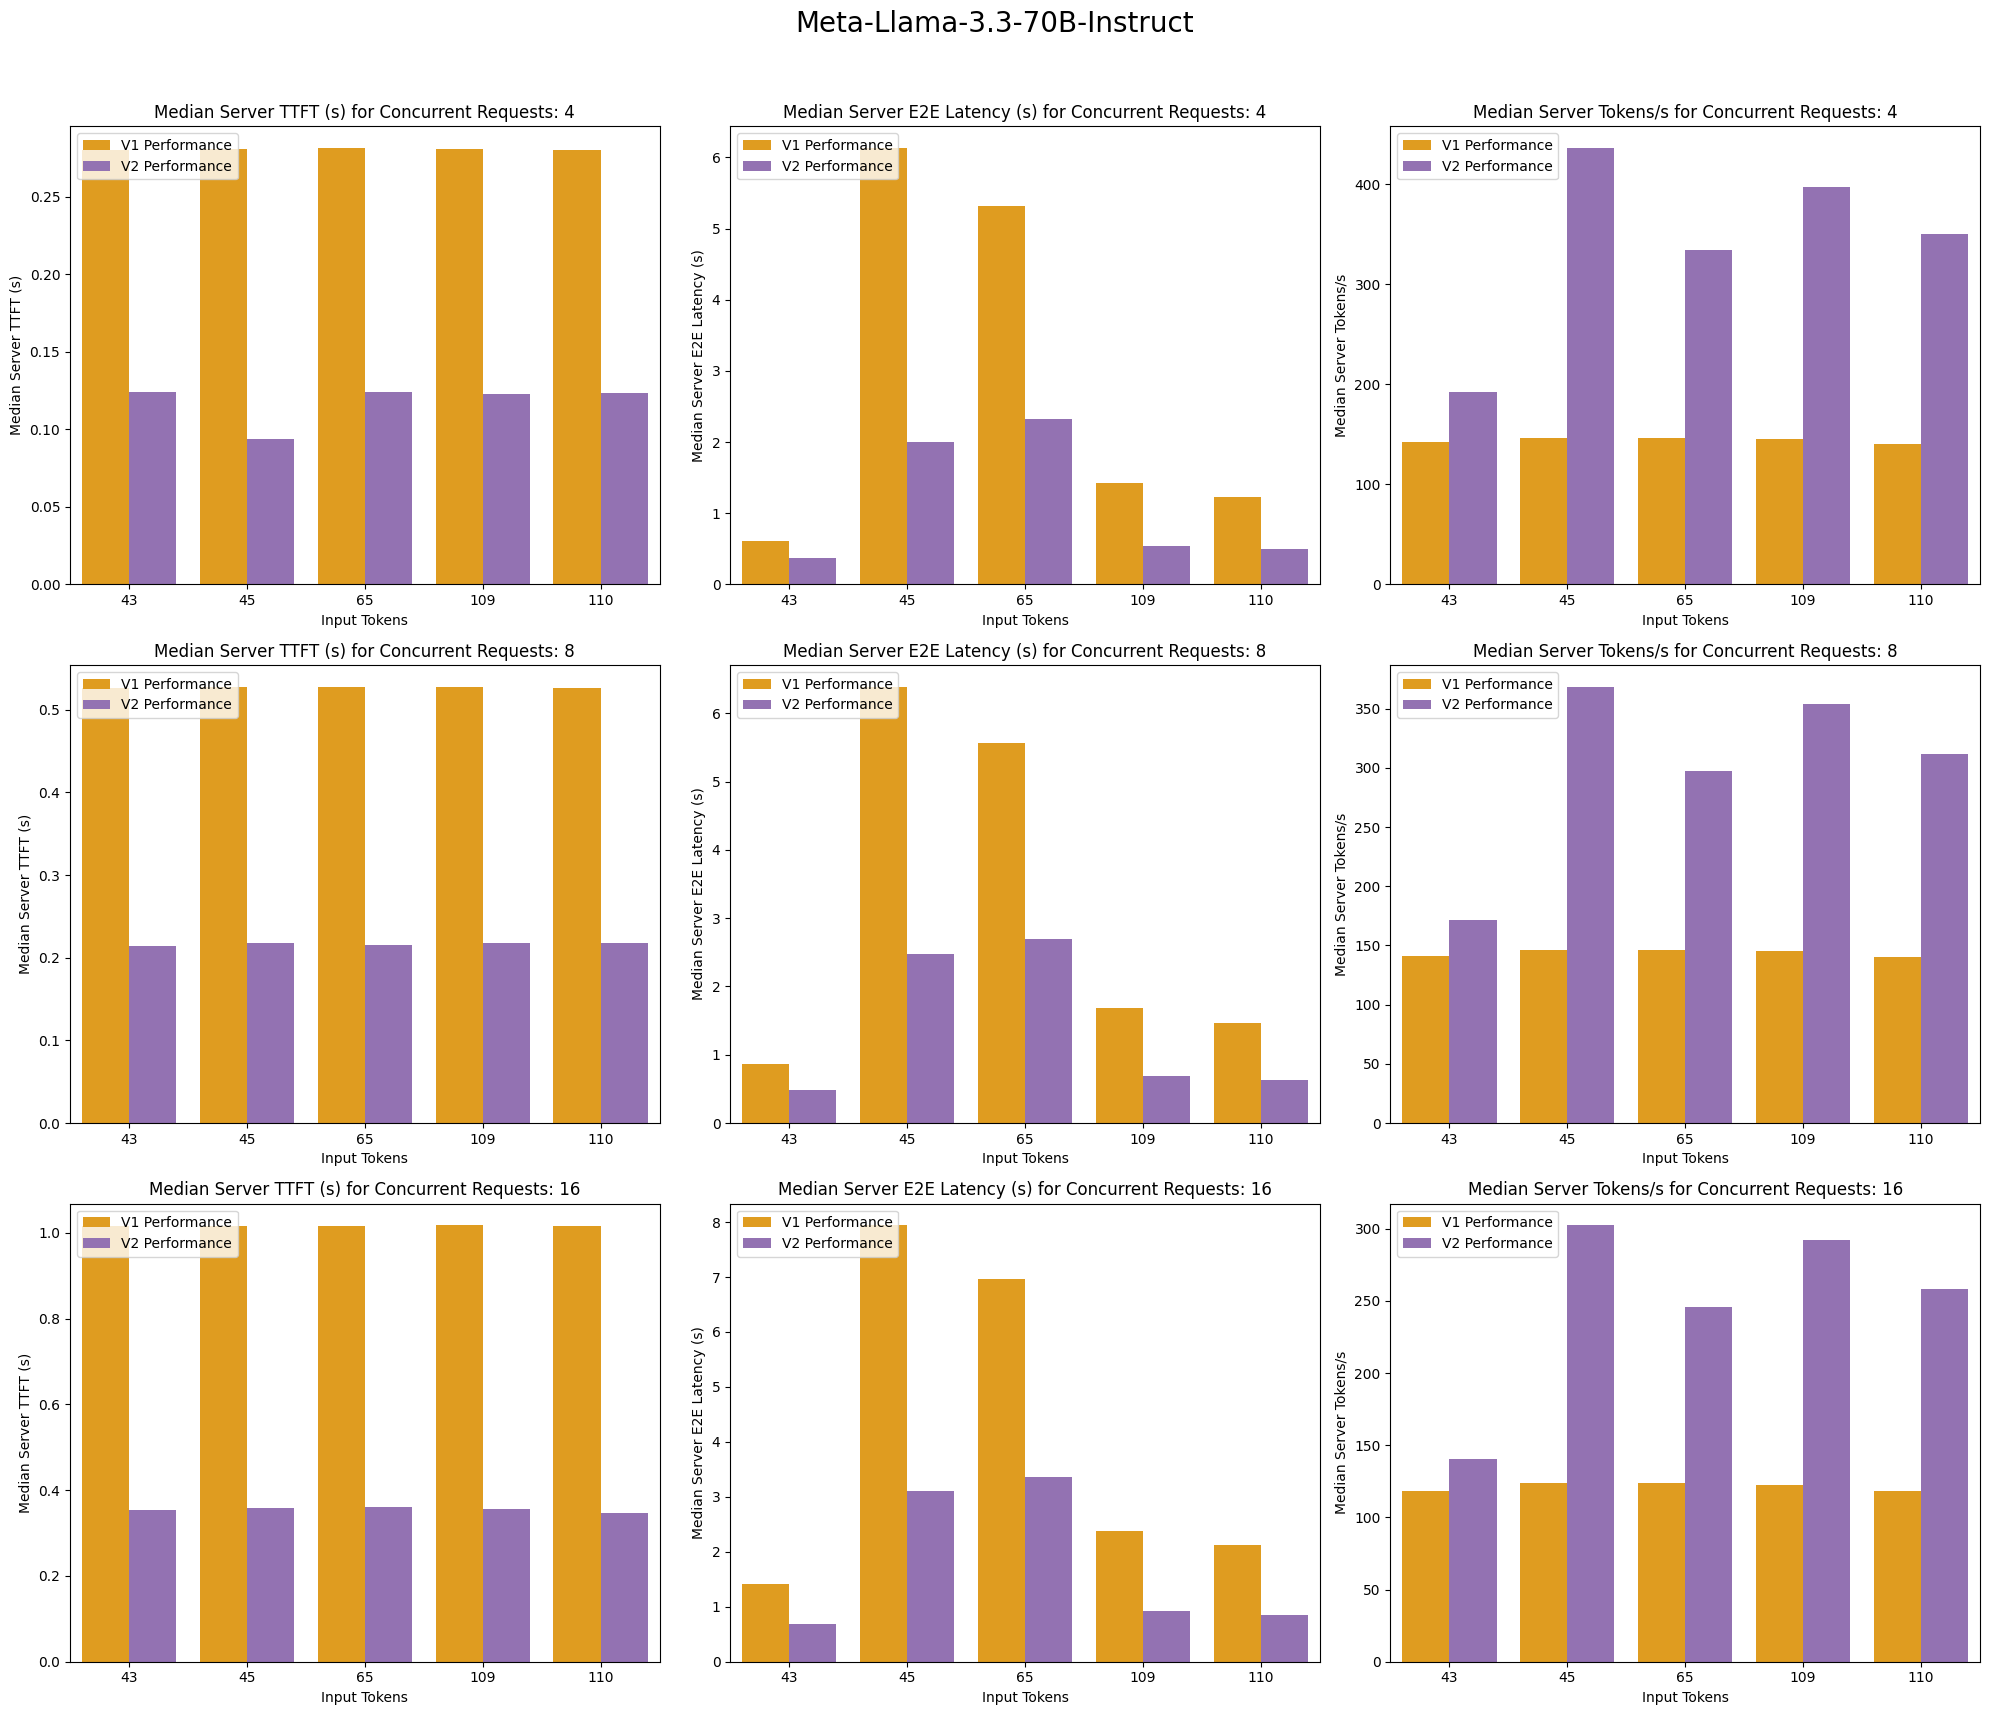

In [ ]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Median Server TTFT (s)": "server_ttft_s_p50",
    "Median Server E2E Latency (s)": "server_end_to_end_latency_s_p50",
    "Median Server Tokens/s": "server_output_token_per_s_p50",
}

# Get unique concurrent values
concurrent_values = sorted(config['concurrent_requests'])
selected_models = ['Meta-Llama-3.3-70B-Instruct']

plt.clf()
for target_model in selected_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

<Figure size 640x480 with 0 Axes>

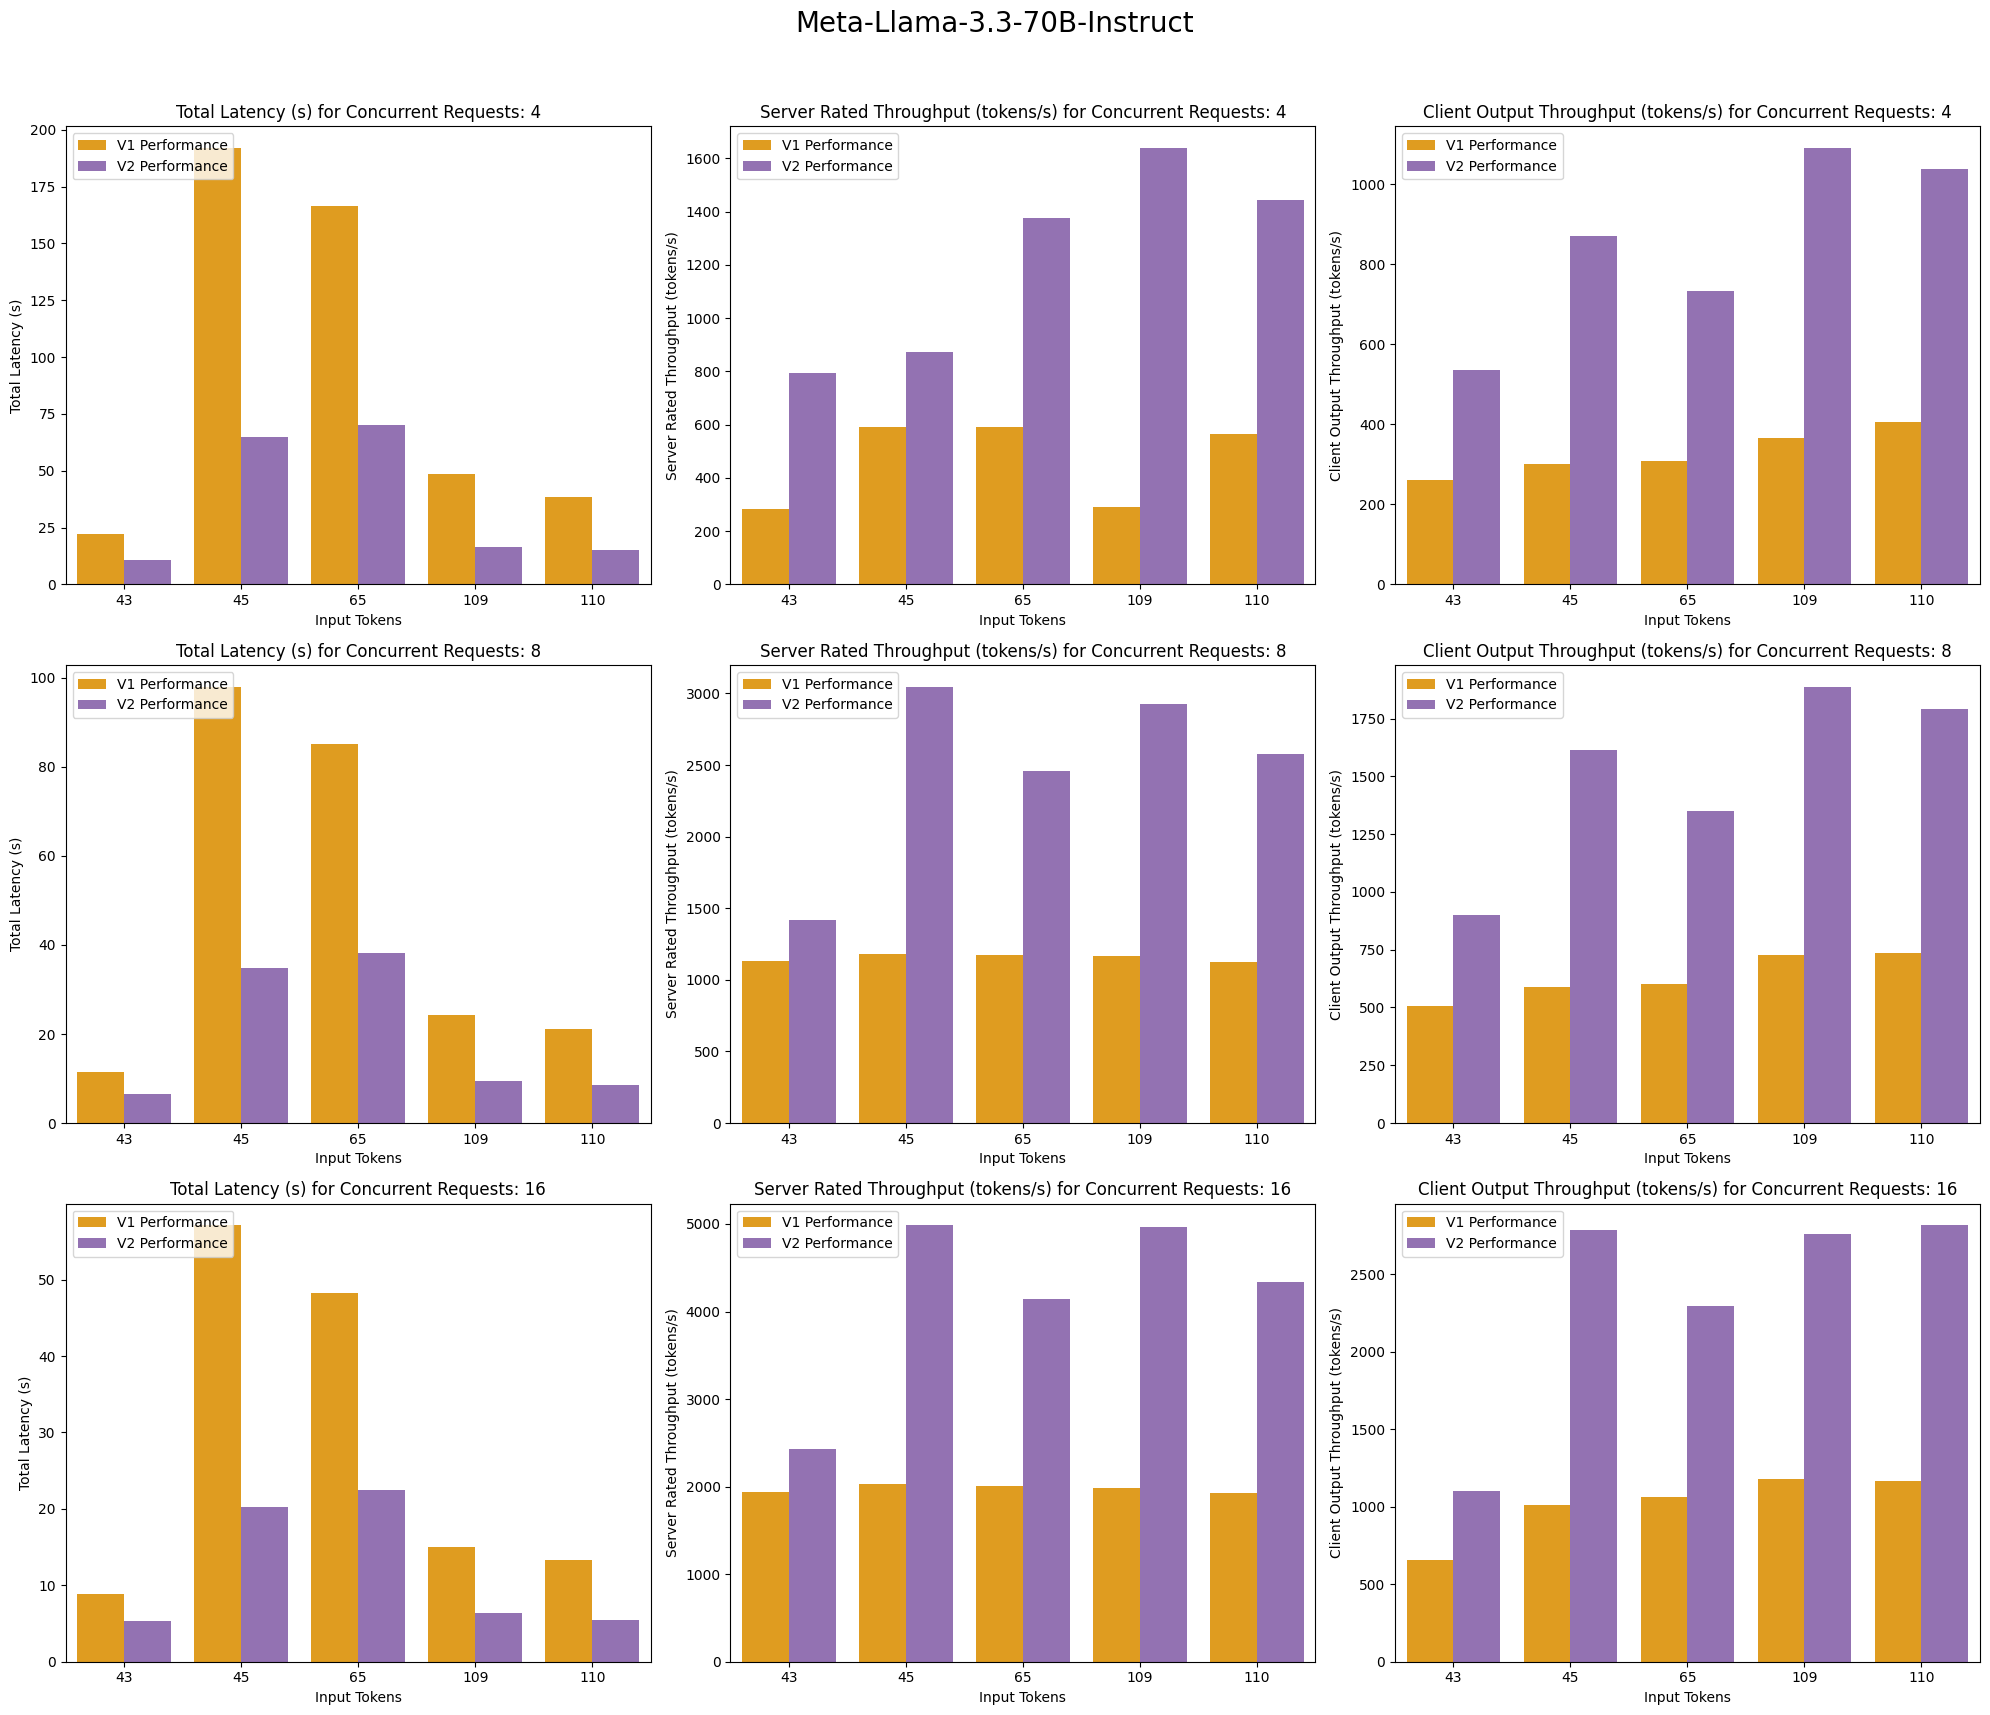

In [ ]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Total Latency (s)": "total_latency",
    "Server Rated Throughput (tokens/s)": "server_rated_throughput",
    "Client Output Throughput (tokens/s)": "client_total_throughput",
}

plt.clf()
for target_model in selected_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='number_input_tokens_min', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()



# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "src")
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "../")
from synthetic_performance_eval_script import *
from benchmarking.utils import read_perf_eval_json_files

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

KeyboardInterrupt: Interrupted by user

#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.2-1B-Instruct', 'Salesforce--Llama-xLAM-2-70b-fc-r']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.2-1B-Instruct', 'Salesforce--Llama-xLAM-2-70b-fc-r']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [ ]:
run_name = "salesforce_xlam2_70b_short_studio_mp1_sfdata_20250606_1"


#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [13]:
target_models = ['Salesforce--Llama-xLAM-2-70b-fc-r'] 

#### Specify custom input path

In [14]:
custom_input_path = os.path.expanduser("~/Downloads/custom_prompt_data.json")

#### Specify configs for benchmarking

In [15]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"

config = {
    'sampling_params': {},
    'max_tokens_to_generate': 1000, # treated as a special sampling param and not to be included in sampling_params  
    'output_files_dir': os.path.join(f'{output_path}logs/output_files/', run_name), # each run saved here
    'consolidated_results_dir': os.path.join(f'{output_path}consolidated_results', run_name), # consolidated xlsx saved here
    'timeout': 3600,
    'num_requests': 64,
    'concurrent_requests': [1, 2, 4, 8, 16, 32],
    'custom_input_path': custom_input_path,
    'save_response_texts': False,
    'llm_api': 'sambastudio'
}

## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Benchmarking produces json files with detailed results for each configuration

In [16]:
for target_model in target_models:
    for num_concurrent_requests in config['concurrent_requests']:        
        custom_evaluator = CustomPromptsPerformanceEvaluator(
            model_name=target_model,        
            results_dir=config['output_files_dir'],
            num_concurrent_requests=num_concurrent_requests,
            timeout=config["timeout"],
            user_metadata={"model_idx": 0},
            input_file_path=config['custom_input_path'],
            save_response_texts=config['save_response_texts'],
            llm_api=config['llm_api'],
        )

        for prompt_id in custom_evaluator.prompt_ids:
            # Run performance evaluation
            custom_evaluator.run_benchmark(
                prompt_id=prompt_id,
                num_output_tokens=config["max_tokens_to_generate"],
                num_requests=config["num_requests"],
                sampling_params=config['sampling_params'])

Running Requests: 100%|██████████| 64/64 [00:34<00:00,  1.75it/s]

2025-06-02 18:09:24,476 [INFO] Tasks Executed!
2025-06-02 18:09:24,477 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:09:24,508 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:09:24,511 [INFO]     p5 = 0.1853
2025-06-02 18:09:24,511 [INFO]     p25 = 0.2384
2025-06-02 18:09:24,512 [INFO]     p50 = 0.3144
2025-06-02 18:09:24,512 [INFO]     p75 = 0.3597
2025-06-02 18:09:24,512 [INFO]     p90 = 0.4661
2025-06-02 18:09:24,512 [INFO]     p95 = 0.5056
2025-06-02 18:09:24,513 [INFO]     p99 = 0.5262
2025-06-02 18:09:24,514 [INFO]     mean = 0.3146
2025-06-02 18:09:24,514 [INFO]     min = 0.1803
2025-06-02 18:09:24,514 [INFO]     max = 0.5317
2025-06-02 18:09:24,514 [INFO]     stddev = 0.0913
2025-06-02 18:09:24,515 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:09:24,516 [INFO]     p5 = 0.4016
2025-06-02 18:09:24,516 [INFO]     p25 = 0.4

Running Requests: 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]


2025-06-02 18:10:56,700 [INFO] Tasks Executed!
2025-06-02 18:10:56,702 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:10:56,717 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:10:56,719 [INFO]     p5 = 0.1935
2025-06-02 18:10:56,719 [INFO]     p25 = 0.2426
2025-06-02 18:10:56,720 [INFO]     p50 = 0.3085
2025-06-02 18:10:56,720 [INFO]     p75 = 0.3502
2025-06-02 18:10:56,720 [INFO]     p90 = 0.423
2025-06-02 18:10:56,721 [INFO]     p95 = 0.5345
2025-06-02 18:10:56,721 [INFO]     p99 = 0.5696
2025-06-02 18:10:56,722 [INFO]     mean = 0.3123
2025-06-02 18:10:56,723 [INFO]     min = 0.1759
2025-06-02 18:10:56,724 [INFO]     max = 0.6141
2025-06-02 18:10:56,724 [INFO]     stddev = 0.0967
2025-06-02 18:10:56,725 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:10:56,726 [INFO]     p5 = 1.2554
2025-06-02 18:10:56,727 [INFO]     p25 = 1.31

Running Requests: 100%|██████████| 64/64 [00:45<00:00,  1.56it/s]

2025-06-02 18:11:41,918 [INFO] Tasks Executed!
2025-06-02 18:11:41,919 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:11:41,932 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:11:41,935 [INFO]     p5 = 0.3542
2025-06-02 18:11:41,936 [INFO]     p25 = 0.4002
2025-06-02 18:11:41,936 [INFO]     p50 = 0.4403
2025-06-02 18:11:41,936 [INFO]     p75 = 0.5334
2025-06-02 18:11:41,937 [INFO]     p90 = 0.5905
2025-06-02 18:11:41,937 [INFO]     p95 = 0.6086
2025-06-02 18:11:41,938 [INFO]     p99 = 0.6458
2025-06-02 18:11:41,938 [INFO]     mean = 0.4685
2025-06-02 18:11:41,938 [INFO]     min = 0.3296
2025-06-02 18:11:41,939 [INFO]     max = 0.6652
2025-06-02 18:11:41,940 [INFO]     stddev = 0.0876
2025-06-02 18:11:41,941 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:11:41,943 [INFO]     p5 = 0.5777
2025-06-02 18:11:41,943 [INFO]     p25 = 0.6

Running Requests: 100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


2025-06-02 18:13:29,474 [INFO] Tasks Executed!
2025-06-02 18:13:29,475 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:13:29,486 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:13:29,488 [INFO]     p5 = 0.3525
2025-06-02 18:13:29,488 [INFO]     p25 = 0.386
2025-06-02 18:13:29,489 [INFO]     p50 = 0.4314
2025-06-02 18:13:29,489 [INFO]     p75 = 0.5058
2025-06-02 18:13:29,490 [INFO]     p90 = 0.5709
2025-06-02 18:13:29,490 [INFO]     p95 = 0.5948
2025-06-02 18:13:29,491 [INFO]     p99 = 0.6515
2025-06-02 18:13:29,492 [INFO]     mean = 0.4513
2025-06-02 18:13:29,492 [INFO]     min = 0.3321
2025-06-02 18:13:29,493 [INFO]     max = 0.6858
2025-06-02 18:13:29,493 [INFO]     stddev = 0.0821
2025-06-02 18:13:29,493 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:13:29,495 [INFO]     p5 = 1.5595
2025-06-02 18:13:29,495 [INFO]     p25 = 1.59

Running Requests: 100%|██████████| 64/64 [01:10<00:00,  1.06s/it]

2025-06-02 18:14:40,107 [INFO] Tasks Executed!
2025-06-02 18:14:40,108 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:14:40,120 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:14:40,122 [INFO]     p5 = 0.52
2025-06-02 18:14:40,123 [INFO]     p25 = 0.552
2025-06-02 18:14:40,123 [INFO]     p50 = 0.6016
2025-06-02 18:14:40,124 [INFO]     p75 = 0.65
2025-06-02 18:14:40,124 [INFO]     p90 = 0.693
2025-06-02 18:14:40,125 [INFO]     p95 = 0.7158
2025-06-02 18:14:40,125 [INFO]     p99 = 0.7404
2025-06-02 18:14:40,126 [INFO]     mean = 0.6039
2025-06-02 18:14:40,126 [INFO]     min = 0.5079
2025-06-02 18:14:40,127 [INFO]     max = 0.7533
2025-06-02 18:14:40,127 [INFO]     stddev = 0.0646
2025-06-02 18:14:40,127 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:14:40,129 [INFO]     p5 = 1.0047
2025-06-02 18:14:40,129 [INFO]     p25 = 1.0378
20

Running Requests: 100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


2025-06-02 18:15:34,907 [INFO] Tasks Executed!
2025-06-02 18:15:34,908 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:15:34,922 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:15:34,925 [INFO]     p5 = 0.5535
2025-06-02 18:15:34,925 [INFO]     p25 = 0.5865
2025-06-02 18:15:34,926 [INFO]     p50 = 0.6307
2025-06-02 18:15:34,926 [INFO]     p75 = 0.6984
2025-06-02 18:15:34,927 [INFO]     p90 = 0.7735
2025-06-02 18:15:34,927 [INFO]     p95 = 0.8078
2025-06-02 18:15:34,927 [INFO]     p99 = 0.8446
2025-06-02 18:15:34,928 [INFO]     mean = 0.6475
2025-06-02 18:15:34,929 [INFO]     min = 0.5206
2025-06-02 18:15:34,929 [INFO]     max = 0.8466
2025-06-02 18:15:34,929 [INFO]     stddev = 0.0809
2025-06-02 18:15:34,930 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:15:34,931 [INFO]     p5 = 0.7479
2025-06-02 18:15:34,931 [INFO]     p25 = 0.7

Running Requests: 100%|██████████| 64/64 [01:27<00:00,  1.38s/it]

2025-06-02 18:17:02,356 [INFO] Tasks Executed!
2025-06-02 18:17:02,357 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:17:02,372 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:17:02,376 [INFO]     p5 = 1.1043
2025-06-02 18:17:02,377 [INFO]     p25 = 1.1325
2025-06-02 18:17:02,377 [INFO]     p50 = 1.2035
2025-06-02 18:17:02,378 [INFO]     p75 = 1.2555
2025-06-02 18:17:02,378 [INFO]     p90 = 1.3115
2025-06-02 18:17:02,379 [INFO]     p95 = 1.3359
2025-06-02 18:17:02,379 [INFO]     p99 = 1.3617
2025-06-02 18:17:02,380 [INFO]     mean = 1.2034
2025-06-02 18:17:02,380 [INFO]     min = 1.0861
2025-06-02 18:17:02,381 [INFO]     max = 1.3672
2025-06-02 18:17:02,381 [INFO]     stddev = 0.074
2025-06-02 18:17:02,381 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:17:02,383 [INFO]     p5 = 1.2443
2025-06-02 18:17:02,383 [INFO]     p25 = 1.29

Running Requests: 100%|██████████| 64/64 [00:17<00:00,  3.72it/s]

2025-06-02 18:17:20,889 [INFO] Tasks Executed!
2025-06-02 18:17:20,890 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:17:20,901 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:17:20,902 [INFO]     p5 = 0.2633
2025-06-02 18:17:20,903 [INFO]     p25 = 0.3523
2025-06-02 18:17:20,903 [INFO]     p50 = 0.3561
2025-06-02 18:17:20,904 [INFO]     p75 = 0.3603
2025-06-02 18:17:20,904 [INFO]     p90 = 0.3685
2025-06-02 18:17:20,905 [INFO]     p95 = 0.4045
2025-06-02 18:17:20,905 [INFO]     p99 = 0.4516
2025-06-02 18:17:20,906 [INFO]     mean = 0.3515
2025-06-02 18:17:20,906 [INFO]     min = 0.1927
2025-06-02 18:17:20,907 [INFO]     max = 0.4635
2025-06-02 18:17:20,907 [INFO]     stddev = 0.0415
2025-06-02 18:17:20,907 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:17:20,909 [INFO]     p5 = 0.4655
2025-06-02 18:17:20,909 [INFO]     p25 = 0.5

Running Requests: 100%|██████████| 64/64 [00:18<00:00,  3.55it/s]


2025-06-02 18:18:34,787 [INFO] Tasks Executed!
2025-06-02 18:18:34,788 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:18:34,802 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:18:34,804 [INFO]     p5 = 1.1311
2025-06-02 18:18:34,805 [INFO]     p25 = 1.2236
2025-06-02 18:18:34,805 [INFO]     p50 = 1.229
2025-06-02 18:18:34,806 [INFO]     p75 = 1.2327
2025-06-02 18:18:34,806 [INFO]     p90 = 1.2381
2025-06-02 18:18:34,806 [INFO]     p95 = 1.2423
2025-06-02 18:18:34,807 [INFO]     p99 = 1.3007
2025-06-02 18:18:34,807 [INFO]     mean = 1.2073
2025-06-02 18:18:34,808 [INFO]     min = 0.2063
2025-06-02 18:18:34,808 [INFO]     max = 1.3523
2025-06-02 18:18:34,808 [INFO]     stddev = 0.1313
2025-06-02 18:18:34,809 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:18:34,811 [INFO]     p5 = 2.2012
2025-06-02 18:18:34,812 [INFO]     p25 = 2.28

Running Requests: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]

2025-06-02 18:19:03,572 [INFO] Tasks Executed!
2025-06-02 18:19:03,574 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:19:03,597 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:19:03,598 [INFO]     p5 = 0.5338
2025-06-02 18:19:03,599 [INFO]     p25 = 0.6365
2025-06-02 18:19:03,599 [INFO]     p50 = 0.6676
2025-06-02 18:19:03,599 [INFO]     p75 = 0.6706
2025-06-02 18:19:03,600 [INFO]     p90 = 0.6737
2025-06-02 18:19:03,600 [INFO]     p95 = 0.6748
2025-06-02 18:19:03,600 [INFO]     p99 = 0.7201
2025-06-02 18:19:03,601 [INFO]     mean = 0.645
2025-06-02 18:19:03,601 [INFO]     min = 0.3489
2025-06-02 18:19:03,601 [INFO]     max = 0.7923
2025-06-02 18:19:03,602 [INFO]     stddev = 0.0611
2025-06-02 18:19:03,602 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:19:03,603 [INFO]     p5 = 0.7532
2025-06-02 18:19:03,603 [INFO]     p25 = 0.87

Running Requests: 100%|██████████| 64/64 [00:28<00:00,  2.22it/s]


2025-06-02 18:20:35,667 [INFO] Tasks Executed!
2025-06-02 18:20:35,670 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:20:35,687 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:20:35,689 [INFO]     p5 = 1.4489
2025-06-02 18:20:35,689 [INFO]     p25 = 1.6258
2025-06-02 18:20:35,690 [INFO]     p50 = 1.6501
2025-06-02 18:20:35,690 [INFO]     p75 = 1.6557
2025-06-02 18:20:35,691 [INFO]     p90 = 1.6602
2025-06-02 18:20:35,691 [INFO]     p95 = 1.666
2025-06-02 18:20:35,691 [INFO]     p99 = 1.7076
2025-06-02 18:20:35,692 [INFO]     mean = 1.6009
2025-06-02 18:20:35,692 [INFO]     min = 0.348
2025-06-02 18:20:35,693 [INFO]     max = 1.7747
2025-06-02 18:20:35,693 [INFO]     stddev = 0.1799
2025-06-02 18:20:35,693 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:20:35,695 [INFO]     p5 = 2.6978
2025-06-02 18:20:35,695 [INFO]     p25 = 2.844

Running Requests: 100%|██████████| 64/64 [00:57<00:00,  1.12it/s]

2025-06-02 18:21:32,990 [INFO] Tasks Executed!
2025-06-02 18:21:32,991 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:21:33,005 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:21:33,006 [INFO]     p5 = 1.2265
2025-06-02 18:21:33,007 [INFO]     p25 = 1.2852
2025-06-02 18:21:33,007 [INFO]     p50 = 1.2909
2025-06-02 18:21:33,008 [INFO]     p75 = 1.2947
2025-06-02 18:21:33,008 [INFO]     p90 = 1.2996
2025-06-02 18:21:33,009 [INFO]     p95 = 1.3321
2025-06-02 18:21:33,009 [INFO]     p99 = 1.3931
2025-06-02 18:21:33,009 [INFO]     mean = 1.2745
2025-06-02 18:21:33,010 [INFO]     min = 0.5469
2025-06-02 18:21:33,010 [INFO]     max = 1.4302
2025-06-02 18:21:33,010 [INFO]     stddev = 0.1043
2025-06-02 18:21:33,010 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:21:33,011 [INFO]     p5 = 1.6996
2025-06-02 18:21:33,012 [INFO]     p25 = 1.7

Running Requests: 100%|██████████| 64/64 [00:57<00:00,  1.11it/s]


2025-06-02 18:22:11,797 [INFO] Tasks Executed!
2025-06-02 18:22:11,800 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:22:11,818 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:22:11,820 [INFO]     p5 = 0.8921
2025-06-02 18:22:11,821 [INFO]     p25 = 0.986
2025-06-02 18:22:11,821 [INFO]     p50 = 0.9966
2025-06-02 18:22:11,822 [INFO]     p75 = 1.0014
2025-06-02 18:22:11,822 [INFO]     p90 = 1.0076
2025-06-02 18:22:11,823 [INFO]     p95 = 1.0275
2025-06-02 18:22:11,823 [INFO]     p99 = 1.0796
2025-06-02 18:22:11,824 [INFO]     mean = 0.979
2025-06-02 18:22:11,824 [INFO]     min = 0.5314
2025-06-02 18:22:11,825 [INFO]     max = 1.1346
2025-06-02 18:22:11,825 [INFO]     stddev = 0.0725
2025-06-02 18:22:11,826 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:22:11,827 [INFO]     p5 = 1.0848
2025-06-02 18:22:11,827 [INFO]     p25 = 1.181

Running Requests: 100%|██████████| 64/64 [01:09<00:00,  1.06s/it]

2025-06-02 18:23:21,682 [INFO] Tasks Executed!
2025-06-02 18:23:21,683 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:23:21,702 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:23:21,704 [INFO]     p5 = 1.8804
2025-06-02 18:23:21,705 [INFO]     p25 = 2.0233
2025-06-02 18:23:21,705 [INFO]     p50 = 2.0353
2025-06-02 18:23:21,706 [INFO]     p75 = 2.0435
2025-06-02 18:23:21,706 [INFO]     p90 = 2.079
2025-06-02 18:23:21,706 [INFO]     p95 = 2.0866
2025-06-02 18:23:21,707 [INFO]     p99 = 2.1406
2025-06-02 18:23:21,707 [INFO]     mean = 2.0109
2025-06-02 18:23:21,708 [INFO]     min = 1.0948
2025-06-02 18:23:21,708 [INFO]     max = 2.1853
2025-06-02 18:23:21,709 [INFO]     stddev = 0.1349
2025-06-02 18:23:21,709 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:23:21,710 [INFO]     p5 = 2.022
2025-06-02 18:23:21,711 [INFO]     p25 = 2.161

Running Requests: 100%|██████████| 64/64 [00:10<00:00,  5.98it/s]

2025-06-02 18:23:32,486 [INFO] Tasks Executed!
2025-06-02 18:23:32,487 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:23:32,503 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:23:32,505 [INFO]     p5 = 0.3994
2025-06-02 18:23:32,505 [INFO]     p25 = 0.4071
2025-06-02 18:23:32,506 [INFO]     p50 = 0.4125
2025-06-02 18:23:32,506 [INFO]     p75 = 0.4317
2025-06-02 18:23:32,507 [INFO]     p90 = 0.4416
2025-06-02 18:23:32,507 [INFO]     p95 = 0.4482
2025-06-02 18:23:32,507 [INFO]     p99 = 0.5363
2025-06-02 18:23:32,508 [INFO]     mean = 0.4168
2025-06-02 18:23:32,509 [INFO]     min = 0.1907
2025-06-02 18:23:32,509 [INFO]     max = 0.5374
2025-06-02 18:23:32,509 [INFO]     stddev = 0.044
2025-06-02 18:23:32,510 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:23:32,511 [INFO]     p5 = 0.6135
2025-06-02 18:23:32,512 [INFO]     p25 = 0.62

Running Requests: 100%|██████████| 64/64 [00:10<00:00,  6.21it/s]


2025-06-02 18:24:12,557 [INFO] Tasks Executed!
2025-06-02 18:24:12,558 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:24:12,569 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:24:12,571 [INFO]     p5 = 1.3285
2025-06-02 18:24:12,571 [INFO]     p25 = 1.3384
2025-06-02 18:24:12,572 [INFO]     p50 = 1.3425
2025-06-02 18:24:12,572 [INFO]     p75 = 1.3479
2025-06-02 18:24:12,572 [INFO]     p90 = 1.3519
2025-06-02 18:24:12,572 [INFO]     p95 = 1.3561
2025-06-02 18:24:12,573 [INFO]     p99 = 1.4864
2025-06-02 18:24:12,573 [INFO]     mean = 1.3127
2025-06-02 18:24:12,574 [INFO]     min = 0.2353
2025-06-02 18:24:12,574 [INFO]     max = 1.4867
2025-06-02 18:24:12,574 [INFO]     stddev = 0.1965
2025-06-02 18:24:12,574 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:24:12,575 [INFO]     p5 = 2.4623
2025-06-02 18:24:12,575 [INFO]     p25 = 2.4

Running Requests: 100%|██████████| 64/64 [00:21<00:00,  2.13it/s]

2025-06-02 18:24:33,681 [INFO] Tasks Executed!
2025-06-02 18:24:33,684 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:24:33,700 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:24:33,702 [INFO]     p5 = 1.0421
2025-06-02 18:24:33,702 [INFO]     p25 = 1.0478
2025-06-02 18:24:33,703 [INFO]     p50 = 1.0543
2025-06-02 18:24:33,703 [INFO]     p75 = 1.0786
2025-06-02 18:24:33,703 [INFO]     p90 = 1.0876
2025-06-02 18:24:33,704 [INFO]     p95 = 1.0957
2025-06-02 18:24:33,704 [INFO]     p99 = 1.1706
2025-06-02 18:24:33,705 [INFO]     mean = 1.0532
2025-06-02 18:24:33,705 [INFO]     min = 0.3336
2025-06-02 18:24:33,705 [INFO]     max = 1.1709
2025-06-02 18:24:33,706 [INFO]     stddev = 0.0956
2025-06-02 18:24:33,706 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:24:33,707 [INFO]     p5 = 1.2885
2025-06-02 18:24:33,707 [INFO]     p25 = 1.2

Running Requests: 100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


2025-06-02 18:25:28,764 [INFO] Tasks Executed!
2025-06-02 18:25:28,765 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:25:28,777 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:25:28,779 [INFO]     p5 = 2.033
2025-06-02 18:25:28,779 [INFO]     p25 = 2.0393
2025-06-02 18:25:28,780 [INFO]     p50 = 2.0479
2025-06-02 18:25:28,780 [INFO]     p75 = 2.1592
2025-06-02 18:25:28,781 [INFO]     p90 = 2.207
2025-06-02 18:25:28,781 [INFO]     p95 = 2.2144
2025-06-02 18:25:28,781 [INFO]     p99 = 2.2177
2025-06-02 18:25:28,783 [INFO]     mean = 2.0617
2025-06-02 18:25:28,783 [INFO]     min = 0.3386
2025-06-02 18:25:28,783 [INFO]     max = 2.2179
2025-06-02 18:25:28,784 [INFO]     stddev = 0.2291
2025-06-02 18:25:28,784 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:25:28,785 [INFO]     p5 = 3.3954
2025-06-02 18:25:28,786 [INFO]     p25 = 3.407

Running Requests:  97%|█████████▋| 62/64 [00:44<00:02,  1.01s/it]

2025-06-02 18:26:12,962 [INFO] Tasks Executed!
2025-06-02 18:26:12,965 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:26:12,983 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:26:12,986 [INFO]     p5 = 2.1534
2025-06-02 18:26:12,986 [INFO]     p25 = 2.1635
2025-06-02 18:26:12,987 [INFO]     p50 = 2.1815
2025-06-02 18:26:12,987 [INFO]     p75 = 2.2431
2025-06-02 18:26:12,987 [INFO]     p90 = 2.2579
2025-06-02 18:26:12,988 [INFO]     p95 = 2.3019
2025-06-02 18:26:12,988 [INFO]     p99 = 2.317
2025-06-02 18:26:12,989 [INFO]     mean = 2.178
2025-06-02 18:26:12,989 [INFO]     min = 0.5354
2025-06-02 18:26:12,989 [INFO]     max = 2.3317
2025-06-02 18:26:12,989 [INFO]     stddev = 0.2139
2025-06-02 18:26:12,990 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:26:12,991 [INFO]     p5 = 2.7208
2025-06-02 18:26:12,991 [INFO]     p25 = 2.73


Running Requests: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


2025-06-02 18:26:46,965 [INFO] Tasks Executed!
2025-06-02 18:26:46,965 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:26:46,978 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:26:46,980 [INFO]     p5 = 1.8223
2025-06-02 18:26:46,980 [INFO]     p25 = 1.8636
2025-06-02 18:26:46,981 [INFO]     p50 = 1.8728
2025-06-02 18:26:46,981 [INFO]     p75 = 1.9071
2025-06-02 18:26:46,981 [INFO]     p90 = 1.9431
2025-06-02 18:26:46,982 [INFO]     p95 = 1.979
2025-06-02 18:26:46,982 [INFO]     p99 = 2.0539
2025-06-02 18:26:46,983 [INFO]     mean = 1.8701
2025-06-02 18:26:46,983 [INFO]     min = 0.5654
2025-06-02 18:26:46,983 [INFO]     max = 2.0541
2025-06-02 18:26:46,983 [INFO]     stddev = 0.1733
2025-06-02 18:26:46,984 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:26:46,985 [INFO]     p5 = 2.0498
2025-06-02 18:26:46,986 [INFO]     p25 = 2.09

Running Requests: 100%|██████████| 64/64 [01:20<00:00,  1.78s/it]

2025-06-02 18:28:07,625 [INFO] Tasks Executed!
2025-06-02 18:28:07,626 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:28:07,642 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:28:07,645 [INFO]     p5 = 4.831
2025-06-02 18:28:07,645 [INFO]     p25 = 4.8472
2025-06-02 18:28:07,646 [INFO]     p50 = 4.8533
2025-06-02 18:28:07,646 [INFO]     p75 = 4.8912
2025-06-02 18:28:07,647 [INFO]     p90 = 4.9653
2025-06-02 18:28:07,647 [INFO]     p95 = 4.995
2025-06-02 18:28:07,648 [INFO]     p99 = 5.1296
2025-06-02 18:28:07,649 [INFO]     mean = 4.8219
2025-06-02 18:28:07,649 [INFO]     min = 1.1233
2025-06-02 18:28:07,649 [INFO]     max = 5.1296
2025-06-02 18:28:07,650 [INFO]     stddev = 0.4762
2025-06-02 18:28:07,650 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:28:07,652 [INFO]     p5 = 4.9569
2025-06-02 18:28:07,652 [INFO]     p25 = 5.010

Running Requests: 100%|██████████| 64/64 [00:06<00:00,  8.76it/s]

2025-06-02 18:28:14,504 [INFO] Tasks Executed!
2025-06-02 18:28:14,505 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:28:14,518 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:28:14,520 [INFO]     p5 = 0.5209
2025-06-02 18:28:14,521 [INFO]     p25 = 0.5379
2025-06-02 18:28:14,521 [INFO]     p50 = 0.5436
2025-06-02 18:28:14,522 [INFO]     p75 = 0.5804
2025-06-02 18:28:14,522 [INFO]     p90 = 0.5973
2025-06-02 18:28:14,523 [INFO]     p95 = 0.6807
2025-06-02 18:28:14,523 [INFO]     p99 = 0.6878
2025-06-02 18:28:14,524 [INFO]     mean = 0.5531
2025-06-02 18:28:14,524 [INFO]     min = 0.2321
2025-06-02 18:28:14,525 [INFO]     max = 0.6882
2025-06-02 18:28:14,525 [INFO]     stddev = 0.0724
2025-06-02 18:28:14,525 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:28:14,527 [INFO]     p5 = 0.7699
2025-06-02 18:28:14,527 [INFO]     p25 = 0.7

Running Requests: 100%|██████████| 64/64 [00:06<00:00,  9.72it/s]


2025-06-02 18:28:37,553 [INFO] Tasks Executed!
2025-06-02 18:28:37,563 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:28:37,617 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:28:37,624 [INFO]     p5 = 1.4564
2025-06-02 18:28:37,627 [INFO]     p25 = 1.4676
2025-06-02 18:28:37,629 [INFO]     p50 = 1.4765
2025-06-02 18:28:37,631 [INFO]     p75 = 1.6389
2025-06-02 18:28:37,632 [INFO]     p90 = 1.6982
2025-06-02 18:28:37,633 [INFO]     p95 = 1.7013
2025-06-02 18:28:37,634 [INFO]     p99 = 1.7088
2025-06-02 18:28:37,639 [INFO]     mean = 1.4977
2025-06-02 18:28:37,641 [INFO]     min = 0.2376
2025-06-02 18:28:37,643 [INFO]     max = 1.7116
2025-06-02 18:28:37,644 [INFO]     stddev = 0.2481
2025-06-02 18:28:37,647 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:28:37,653 [INFO]     p5 = 2.8044
2025-06-02 18:28:37,653 [INFO]     p25 = 2.8

Running Requests: 100%|██████████| 64/64 [00:15<00:00,  2.99it/s]

2025-06-02 18:28:52,872 [INFO] Tasks Executed!
2025-06-02 18:28:52,873 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:28:52,885 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:28:52,887 [INFO]     p5 = 1.5713
2025-06-02 18:28:52,888 [INFO]     p25 = 1.5886
2025-06-02 18:28:52,888 [INFO]     p50 = 1.6292
2025-06-02 18:28:52,888 [INFO]     p75 = 1.691
2025-06-02 18:28:52,889 [INFO]     p90 = 1.7001
2025-06-02 18:28:52,889 [INFO]     p95 = 1.7037
2025-06-02 18:28:52,890 [INFO]     p99 = 1.7054
2025-06-02 18:28:52,891 [INFO]     mean = 1.614
2025-06-02 18:28:52,891 [INFO]     min = 0.334
2025-06-02 18:28:52,891 [INFO]     max = 1.7077
2025-06-02 18:28:52,892 [INFO]     stddev = 0.1699
2025-06-02 18:28:52,892 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:28:52,894 [INFO]     p5 = 1.852
2025-06-02 18:28:52,894 [INFO]     p25 = 1.8638


Running Requests: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


2025-06-02 18:29:26,287 [INFO] Tasks Executed!
2025-06-02 18:29:26,288 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:29:26,298 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:29:26,300 [INFO]     p5 = 2.5705
2025-06-02 18:29:26,300 [INFO]     p25 = 2.5866
2025-06-02 18:29:26,300 [INFO]     p50 = 2.6237
2025-06-02 18:29:26,300 [INFO]     p75 = 2.664
2025-06-02 18:29:26,301 [INFO]     p90 = 2.867
2025-06-02 18:29:26,301 [INFO]     p95 = 2.9274
2025-06-02 18:29:26,301 [INFO]     p99 = 2.9295
2025-06-02 18:29:26,302 [INFO]     mean = 2.627
2025-06-02 18:29:26,302 [INFO]     min = 0.4693
2025-06-02 18:29:26,303 [INFO]     max = 2.9308
2025-06-02 18:29:26,303 [INFO]     stddev = 0.2939
2025-06-02 18:29:26,303 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:29:26,304 [INFO]     p5 = 4.107
2025-06-02 18:29:26,305 [INFO]     p25 = 4.1187


Running Requests: 100%|██████████| 64/64 [00:35<00:00,  1.02s/it]

2025-06-02 18:30:02,022 [INFO] Tasks Executed!
2025-06-02 18:30:02,023 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:30:02,030 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:30:02,032 [INFO]     p5 = 3.7187
2025-06-02 18:30:02,032 [INFO]     p25 = 3.7315
2025-06-02 18:30:02,032 [INFO]     p50 = 3.7711
2025-06-02 18:30:02,032 [INFO]     p75 = 3.8889
2025-06-02 18:30:02,032 [INFO]     p90 = 3.9166
2025-06-02 18:30:02,033 [INFO]     p95 = 3.9584
2025-06-02 18:30:02,033 [INFO]     p99 = 4.0243
2025-06-02 18:30:02,034 [INFO]     mean = 3.7186
2025-06-02 18:30:02,034 [INFO]     min = 0.8884
2025-06-02 18:30:02,034 [INFO]     max = 4.025
2025-06-02 18:30:02,035 [INFO]     stddev = 0.5196
2025-06-02 18:30:02,035 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:30:02,036 [INFO]     p5 = 4.4122
2025-06-02 18:30:02,036 [INFO]     p25 = 4.41

Running Requests: 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


2025-06-02 18:30:29,136 [INFO] Tasks Executed!
2025-06-02 18:30:29,137 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:30:29,148 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:30:29,149 [INFO]     p5 = 3.0465
2025-06-02 18:30:29,150 [INFO]     p25 = 3.0554
2025-06-02 18:30:29,150 [INFO]     p50 = 3.066
2025-06-02 18:30:29,150 [INFO]     p75 = 3.0804
2025-06-02 18:30:29,151 [INFO]     p90 = 3.222
2025-06-02 18:30:29,151 [INFO]     p95 = 3.2316
2025-06-02 18:30:29,151 [INFO]     p99 = 3.2337
2025-06-02 18:30:29,152 [INFO]     mean = 3.0537
2025-06-02 18:30:29,152 [INFO]     min = 0.6499
2025-06-02 18:30:29,153 [INFO]     max = 3.2344
2025-06-02 18:30:29,153 [INFO]     stddev = 0.311
2025-06-02 18:30:29,153 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:30:29,154 [INFO]     p5 = 3.3252
2025-06-02 18:30:29,155 [INFO]     p25 = 3.3296

Running Requests:  92%|█████████▏| 59/64 [01:09<00:16,  3.36s/it]

2025-06-02 18:31:38,695 [INFO] Tasks Executed!
2025-06-02 18:31:38,696 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:31:38,709 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:31:38,711 [INFO]     p5 = 8.444
2025-06-02 18:31:38,712 [INFO]     p25 = 8.4536
2025-06-02 18:31:38,712 [INFO]     p50 = 8.465
2025-06-02 18:31:38,712 [INFO]     p75 = 8.5121
2025-06-02 18:31:38,713 [INFO]     p90 = 8.5938
2025-06-02 18:31:38,713 [INFO]     p95 = 8.598
2025-06-02 18:31:38,713 [INFO]     p99 = 8.5987
2025-06-02 18:31:38,714 [INFO]     mean = 8.3729
2025-06-02 18:31:38,714 [INFO]     min = 1.0793
2025-06-02 18:31:38,714 [INFO]     max = 8.5994
2025-06-02 18:31:38,714 [INFO]     stddev = 0.9275
2025-06-02 18:31:38,715 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:31:38,716 [INFO]     p5 = 8.6431
2025-06-02 18:31:38,716 [INFO]     p25 = 8.651


Running Requests: 100%|██████████| 64/64 [00:04<00:00,  9.89it/s]

2025-06-02 18:31:43,971 [INFO] Tasks Executed!
2025-06-02 18:31:43,972 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:31:43,987 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:31:43,989 [INFO]     p5 = 0.7431
2025-06-02 18:31:43,989 [INFO]     p25 = 0.7666
2025-06-02 18:31:43,989 [INFO]     p50 = 0.8593
2025-06-02 18:31:43,990 [INFO]     p75 = 0.9502
2025-06-02 18:31:43,990 [INFO]     p90 = 0.9871
2025-06-02 18:31:43,990 [INFO]     p95 = 1.2576
2025-06-02 18:31:43,991 [INFO]     p99 = 1.3339
2025-06-02 18:31:43,992 [INFO]     mean = 0.8676
2025-06-02 18:31:43,992 [INFO]     min = 0.2342
2025-06-02 18:31:43,992 [INFO]     max = 1.3423
2025-06-02 18:31:43,993 [INFO]     stddev = 0.1811
2025-06-02 18:31:43,993 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:31:43,995 [INFO]     p5 = 1.0433
2025-06-02 18:31:43,995 [INFO]     p25 = 1.0

Running Requests: 100%|██████████| 64/64 [00:04<00:00, 12.86it/s]


2025-06-02 18:31:57,023 [INFO] Tasks Executed!
2025-06-02 18:31:57,024 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:31:57,032 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:31:57,033 [INFO]     p5 = 1.5268
2025-06-02 18:31:57,034 [INFO]     p25 = 1.566
2025-06-02 18:31:57,034 [INFO]     p50 = 1.6217
2025-06-02 18:31:57,034 [INFO]     p75 = 1.7069
2025-06-02 18:31:57,035 [INFO]     p90 = 1.7127
2025-06-02 18:31:57,035 [INFO]     p95 = 1.7196
2025-06-02 18:31:57,036 [INFO]     p99 = 2.1345
2025-06-02 18:31:57,036 [INFO]     mean = 1.6195
2025-06-02 18:31:57,036 [INFO]     min = 0.1812
2025-06-02 18:31:57,037 [INFO]     max = 2.1464
2025-06-02 18:31:57,037 [INFO]     stddev = 0.2223
2025-06-02 18:31:57,038 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:31:57,039 [INFO]     p5 = 3.1768
2025-06-02 18:31:57,039 [INFO]     p25 = 3.18

Running Requests: 100%|██████████| 64/64 [00:13<00:00,  1.81it/s]

2025-06-02 18:32:10,914 [INFO] Tasks Executed!
2025-06-02 18:32:10,915 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:32:10,930 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:32:10,932 [INFO]     p5 = 2.7915
2025-06-02 18:32:10,932 [INFO]     p25 = 2.8039
2025-06-02 18:32:10,933 [INFO]     p50 = 3.0269
2025-06-02 18:32:10,933 [INFO]     p75 = 3.1459
2025-06-02 18:32:10,933 [INFO]     p90 = 3.1638
2025-06-02 18:32:10,934 [INFO]     p95 = 3.2951
2025-06-02 18:32:10,934 [INFO]     p99 = 3.6373
2025-06-02 18:32:10,935 [INFO]     mean = 2.9628
2025-06-02 18:32:10,935 [INFO]     min = 0.3347
2025-06-02 18:32:10,935 [INFO]     max = 3.6428
2025-06-02 18:32:10,936 [INFO]     stddev = 0.395
2025-06-02 18:32:10,936 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:32:10,938 [INFO]     p5 = 3.0254
2025-06-02 18:32:10,938 [INFO]     p25 = 3.13

Running Requests: 100%|██████████| 64/64 [00:13<00:00,  4.63it/s]


2025-06-02 18:32:33,519 [INFO] Tasks Executed!
2025-06-02 18:32:33,519 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:32:33,528 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:32:33,530 [INFO]     p5 = 3.6369
2025-06-02 18:32:33,530 [INFO]     p25 = 3.6613
2025-06-02 18:32:33,530 [INFO]     p50 = 3.6868
2025-06-02 18:32:33,531 [INFO]     p75 = 3.7831
2025-06-02 18:32:33,531 [INFO]     p90 = 3.7928
2025-06-02 18:32:33,531 [INFO]     p95 = 3.8026
2025-06-02 18:32:33,532 [INFO]     p99 = 4.3735
2025-06-02 18:32:33,532 [INFO]     mean = 3.681
2025-06-02 18:32:33,532 [INFO]     min = 0.351
2025-06-02 18:32:33,533 [INFO]     max = 4.3758
2025-06-02 18:32:33,533 [INFO]     stddev = 0.4489
2025-06-02 18:32:33,533 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:32:33,534 [INFO]     p5 = 5.5329
2025-06-02 18:32:33,534 [INFO]     p25 = 5.544

Running Requests:  81%|████████▏ | 52/64 [00:26<00:29,  2.47s/it]

2025-06-02 18:33:00,323 [INFO] Tasks Executed!
2025-06-02 18:33:00,324 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:33:00,336 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:33:00,337 [INFO]     p5 = 5.6886
2025-06-02 18:33:00,338 [INFO]     p25 = 5.6989
2025-06-02 18:33:00,338 [INFO]     p50 = 5.7167
2025-06-02 18:33:00,339 [INFO]     p75 = 5.8175
2025-06-02 18:33:00,339 [INFO]     p90 = 5.8251
2025-06-02 18:33:00,340 [INFO]     p95 = 5.8276
2025-06-02 18:33:00,340 [INFO]     p99 = 6.1638
2025-06-02 18:33:00,342 [INFO]     mean = 5.6745
2025-06-02 18:33:00,342 [INFO]     min = 0.5108
2025-06-02 18:33:00,342 [INFO]     max = 6.1745
2025-06-02 18:33:00,343 [INFO]     stddev = 0.6638
2025-06-02 18:33:00,343 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:33:00,345 [INFO]     p5 = 6.6246
2025-06-02 18:33:00,345 [INFO]     p25 = 6.6

Running Requests: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s]


2025-06-02 18:33:25,668 [INFO] Tasks Executed!
2025-06-02 18:33:25,669 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:33:25,682 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:33:25,684 [INFO]     p5 = 5.3621
2025-06-02 18:33:25,684 [INFO]     p25 = 5.3724
2025-06-02 18:33:25,685 [INFO]     p50 = 5.5454
2025-06-02 18:33:25,685 [INFO]     p75 = 6.0669
2025-06-02 18:33:25,686 [INFO]     p90 = 6.3602
2025-06-02 18:33:25,686 [INFO]     p95 = 6.3683
2025-06-02 18:33:25,686 [INFO]     p99 = 7.0325
2025-06-02 18:33:25,687 [INFO]     mean = 5.6337
2025-06-02 18:33:25,687 [INFO]     min = 0.6045
2025-06-02 18:33:25,688 [INFO]     max = 7.0333
2025-06-02 18:33:25,688 [INFO]     stddev = 0.7857
2025-06-02 18:33:25,688 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:33:25,690 [INFO]     p5 = 5.7559
2025-06-02 18:33:25,690 [INFO]     p25 = 5.7

Running Requests:  78%|███████▊  | 50/64 [01:04<00:24,  1.78s/it]

2025-06-02 18:34:30,014 [INFO] Tasks Executed!
2025-06-02 18:34:30,015 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:34:30,026 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:34:30,028 [INFO]     p5 = 15.7
2025-06-02 18:34:30,028 [INFO]     p25 = 15.7513
2025-06-02 18:34:30,029 [INFO]     p50 = 15.8054
2025-06-02 18:34:30,029 [INFO]     p75 = 15.8848
2025-06-02 18:34:30,029 [INFO]     p90 = 15.8912
2025-06-02 18:34:30,030 [INFO]     p95 = 15.8931
2025-06-02 18:34:30,030 [INFO]     p99 = 15.8973
2025-06-02 18:34:30,031 [INFO]     mean = 15.572
2025-06-02 18:34:30,031 [INFO]     min = 1.1127
2025-06-02 18:34:30,032 [INFO]     max = 15.8986
2025-06-02 18:34:30,032 [INFO]     stddev = 1.8374
2025-06-02 18:34:30,032 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:34:30,035 [INFO]     p5 = 15.9866
2025-06-02 18:34:30,035 [INFO]     p25

Running Requests: 100%|██████████| 64/64 [00:04<00:00,  3.42it/s]

2025-06-02 18:34:34,667 [INFO] Tasks Executed!
2025-06-02 18:34:34,668 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:34:34,683 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:34:34,685 [INFO]     p5 = 0.5982
2025-06-02 18:34:34,685 [INFO]     p25 = 1.4628
2025-06-02 18:34:34,686 [INFO]     p50 = 1.5561
2025-06-02 18:34:34,686 [INFO]     p75 = 1.6538
2025-06-02 18:34:34,687 [INFO]     p90 = 1.7107
2025-06-02 18:34:34,687 [INFO]     p95 = 2.1183
2025-06-02 18:34:34,688 [INFO]     p99 = 2.5596
2025-06-02 18:34:34,688 [INFO]     mean = 1.5088
2025-06-02 18:34:34,689 [INFO]     min = 0.1877
2025-06-02 18:34:34,689 [INFO]     max = 2.5616
2025-06-02 18:34:34,689 [INFO]     stddev = 0.4219
2025-06-02 18:34:34,690 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:34:34,691 [INFO]     p5 = 0.8369
2025-06-02 18:34:34,692 [INFO]     p25 = 1.9

Running Requests: 100%|██████████| 64/64 [00:04<00:00, 14.41it/s]


2025-06-02 18:34:43,721 [INFO] Tasks Executed!
2025-06-02 18:34:43,721 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:34:43,729 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:34:43,730 [INFO]     p5 = 1.8649
2025-06-02 18:34:43,731 [INFO]     p25 = 1.8906
2025-06-02 18:34:43,731 [INFO]     p50 = 1.9508
2025-06-02 18:34:43,731 [INFO]     p75 = 2.0
2025-06-02 18:34:43,732 [INFO]     p90 = 2.0026
2025-06-02 18:34:43,732 [INFO]     p95 = 2.0043
2025-06-02 18:34:43,732 [INFO]     p99 = 2.5028
2025-06-02 18:34:43,733 [INFO]     mean = 1.9388
2025-06-02 18:34:43,733 [INFO]     min = 0.1946
2025-06-02 18:34:43,733 [INFO]     max = 3.3485
2025-06-02 18:34:43,733 [INFO]     stddev = 0.2881
2025-06-02 18:34:43,734 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:34:43,735 [INFO]     p5 = 4.3598
2025-06-02 18:34:43,735 [INFO]     p25 = 4.3833

Running Requests: 100%|██████████| 64/64 [00:15<00:00,  1.26it/s]

2025-06-02 18:34:59,377 [INFO] Tasks Executed!
2025-06-02 18:34:59,378 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:34:59,387 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:34:59,389 [INFO]     p5 = 4.8505
2025-06-02 18:34:59,390 [INFO]     p25 = 4.8635
2025-06-02 18:34:59,390 [INFO]     p50 = 6.9723
2025-06-02 18:34:59,391 [INFO]     p75 = 7.1422
2025-06-02 18:34:59,391 [INFO]     p90 = 7.6138
2025-06-02 18:34:59,392 [INFO]     p95 = 7.617
2025-06-02 18:34:59,392 [INFO]     p99 = 7.6205
2025-06-02 18:34:59,393 [INFO]     mean = 6.4819
2025-06-02 18:34:59,393 [INFO]     min = 0.343
2025-06-02 18:34:59,394 [INFO]     max = 7.6228
2025-06-02 18:34:59,394 [INFO]     stddev = 1.3268
2025-06-02 18:34:59,395 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:34:59,396 [INFO]     p5 = 5.3664
2025-06-02 18:34:59,396 [INFO]     p25 = 5.374

Running Requests: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


2025-06-02 18:35:17,142 [INFO] Tasks Executed!
2025-06-02 18:35:17,143 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:35:17,151 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:35:17,152 [INFO]     p5 = 5.8941
2025-06-02 18:35:17,153 [INFO]     p25 = 5.9227
2025-06-02 18:35:17,153 [INFO]     p50 = 5.9625
2025-06-02 18:35:17,153 [INFO]     p75 = 5.9972
2025-06-02 18:35:17,153 [INFO]     p90 = 6.0111
2025-06-02 18:35:17,153 [INFO]     p95 = 6.0346
2025-06-02 18:35:17,154 [INFO]     p99 = 6.5887
2025-06-02 18:35:17,154 [INFO]     mean = 5.8967
2025-06-02 18:35:17,154 [INFO]     min = 0.3509
2025-06-02 18:35:17,155 [INFO]     max = 7.5002
2025-06-02 18:35:17,155 [INFO]     stddev = 0.7313
2025-06-02 18:35:17,155 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:35:17,156 [INFO]     p5 = 8.6479
2025-06-02 18:35:17,156 [INFO]     p25 = 8.6

Running Requests:  81%|████████▏ | 52/64 [00:24<00:23,  1.92s/it]

2025-06-02 18:35:41,342 [INFO] Tasks Executed!
2025-06-02 18:35:41,343 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:35:41,355 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:35:41,356 [INFO]     p5 = 5.8414
2025-06-02 18:35:41,357 [INFO]     p25 = 5.8714
2025-06-02 18:35:41,357 [INFO]     p50 = 10.5238
2025-06-02 18:35:41,358 [INFO]     p75 = 10.5531
2025-06-02 18:35:41,358 [INFO]     p90 = 11.5555
2025-06-02 18:35:41,358 [INFO]     p95 = 11.5567
2025-06-02 18:35:41,359 [INFO]     p99 = 11.5577
2025-06-02 18:35:41,360 [INFO]     mean = 9.4433
2025-06-02 18:35:41,360 [INFO]     min = 0.526
2025-06-02 18:35:41,361 [INFO]     max = 11.5578
2025-06-02 18:35:41,361 [INFO]     stddev = 2.4891
2025-06-02 18:35:41,361 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:35:41,363 [INFO]     p5 = 6.7602
2025-06-02 18:35:41,363 [INFO]     p25 

Running Requests: 100%|██████████| 64/64 [00:24<00:00,  2.65it/s]


2025-06-02 18:36:03,089 [INFO] Tasks Executed!
2025-06-02 18:36:03,090 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:36:03,098 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:36:03,100 [INFO]     p5 = 5.6003
2025-06-02 18:36:03,100 [INFO]     p25 = 5.6602
2025-06-02 18:36:03,100 [INFO]     p50 = 9.9442
2025-06-02 18:36:03,101 [INFO]     p75 = 9.986
2025-06-02 18:36:03,101 [INFO]     p90 = 10.7749
2025-06-02 18:36:03,101 [INFO]     p95 = 10.7916
2025-06-02 18:36:03,101 [INFO]     p99 = 10.7979
2025-06-02 18:36:03,102 [INFO]     mean = 8.9168
2025-06-02 18:36:03,103 [INFO]     min = 0.7319
2025-06-02 18:36:03,103 [INFO]     max = 10.7992
2025-06-02 18:36:03,103 [INFO]     stddev = 2.2786
2025-06-02 18:36:03,104 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:36:03,105 [INFO]     p5 = 5.9572
2025-06-02 18:36:03,106 [INFO]     p25 = 

Running Requests: 100%|██████████| 64/64 [01:01<00:00,  3.27s/it]

2025-06-02 18:37:04,318 [INFO] Tasks Executed!
2025-06-02 18:37:04,319 [INFO] Benchmarking results obtained for model Salesforce--Llama-xLAM-2-70b-fc-r queried with the sambastudio API.
2025-06-02 18:37:04,332 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-02 18:37:04,334 [INFO]     p5 = 15.9647
2025-06-02 18:37:04,334 [INFO]     p25 = 15.9784
2025-06-02 18:37:04,334 [INFO]     p50 = 29.5466
2025-06-02 18:37:04,335 [INFO]     p75 = 29.5711
2025-06-02 18:37:04,335 [INFO]     p90 = 30.8497
2025-06-02 18:37:04,336 [INFO]     p95 = 30.8524
2025-06-02 18:37:04,336 [INFO]     p99 = 30.8618
2025-06-02 18:37:04,337 [INFO]     mean = 26.0147
2025-06-02 18:37:04,337 [INFO]     min = 1.1425
2025-06-02 18:37:04,337 [INFO]     max = 30.8627
2025-06-02 18:37:04,338 [INFO]     stddev = 6.8819
2025-06-02 18:37:04,338 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-02 18:37:04,339 [INFO]     p5 = 16.2078
2025-06-02 18:37:04,339 [INFO]    

#### Consolidate all results into pandas dataframe

In [ ]:
output_files_dir = config['output_files_dir']
df_summary = read_perf_eval_json_files(output_files_dir, type='summary')

missing_columns = []

if 'num_concurrent_requests' not in df_summary.columns:
    missing_columns.append('num_concurrent_requests')

if 'multimodal_img_size' not in df_summary.columns or df_summary['multimodal_img_size'].isnull().all():
    missing_columns.append('multimodal_img_size')

# Set fields to report
selected_columns = [
    'name',
    'model',
    'prompt_id',
    'number_input_tokens_min',
    'number_input_tokens_max',
    'num_output_tokens',
    'num_concurrent_requests',
    'multimodal_img_size',
    'server_ttft_s_min',
    'server_ttft_s_p50',
    'server_ttft_s_max',
    'server_ttft_s_mean',
    'server_end_to_end_latency_s_min',
    'server_end_to_end_latency_s_p50',
    'server_end_to_end_latency_s_max',
    'server_end_to_end_latency_s_mean',
    'server_output_token_per_s_min',
    'server_output_token_per_s_p50',
    'server_output_token_per_s_max',
    'server_output_token_per_s_mean',                
    'acceptance_rate_min',
    'acceptance_rate_p50',
    'acceptance_rate_max',
    'server_number_input_tokens_p50',
    'server_number_output_tokens_p50',
    'client_ttft_s_min',
    'client_ttft_s_p50',
    'client_ttft_s_max',
    'client_ttft_s_mean',
    'client_end_to_end_latency_s_min',
    'client_end_to_end_latency_s_p50',
    'client_end_to_end_latency_s_max',
    'client_end_to_end_latency_s_mean',
    'client_output_token_per_s_min',
    'client_output_token_per_s_p50',
    'client_output_token_per_s_max',
    'client_output_token_per_s_mean',
    'client_mean_output_token_per_s',
    'num_requests_started',
    'num_completed_requests',
    'num_completed_requests_per_min',
    'number_errors',
    'error_code_frequency',
]

selected_columns = [c for c in selected_columns if c not in missing_columns]
# Set fields to report
df_summary = df_summary[selected_columns]
df_summary['model'] = df_summary['model'].str.replace('.', '-')
df_summary['requests_grouping'] = pd.Series(None, index=df_summary.index, dtype=object)
df_summary['requests_batching'] = pd.Series(None, index=df_summary.index, dtype=object)

# Add UUID to summary and set as index
#df_summary['uuid'] = df_summary.apply(lambda x: find_uuid(x['name']), axis=1)
df_summary = df_summary.set_index('name')

# Read individual responses
df = read_perf_eval_json_files(output_files_dir, type='individual_responses')

# Process individual files and add requests batching approximation
for filename in os.listdir(output_files_dir):
    if 'individual_responses' in filename:
        df_file = df[df['filename'] == filename].copy()
        df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)

        key = filename[:filename.index("_individual_responses.json")] + "_summary"        
        
        start_time = pd.to_datetime(df_file["start_time"]).min()
        end_time = pd.to_datetime(df_file["end_time"]).max()
        total_latency = (end_time - start_time).total_seconds()
        total_tokens_generated = df_file["number_output_tokens"].sum()
        #generation_latency = (df_file["client_end_to_end_latency_s"]-df_file["client_ttft_s"]).sum()

        if key in df_summary.index:
            df_summary.at[key, 'requests_grouping'] = requests_grouping
            df_summary.at[key, 'requests_batching'] = requests_batching
            df_summary.at[key, 'total_tokens_generated'] = total_tokens_generated
            df_summary.at[key, 'total_latency'] = total_latency
            df_summary.at[key, 'generation_latency'] = generation_latency            
        else:
            raise KeyError(f'Key {key} not found in dictionary. File: {file}')
df_summary['representative_batch_size'] = df_summary['requests_batching'].apply(
    lambda x: find_median_in_batches(x)
)

# Sort and save the summary DataFrame
consolidated_results_dir = os.path.expanduser(config['consolidated_results_dir'])
if not os.path.exists(consolidated_results_dir):
    os.makedirs(consolidated_results_dir)

sort_columns = ['model', 'prompt_id', 'num_output_tokens', 'num_concurrent_requests']
if 'num_concurrent_requests' in df_summary.columns:
    sort_columns.append('num_concurrent_requests')
df_summary.sort_values(by=sort_columns, inplace=True)
df_summary.to_excel(os.path.join(consolidated_results_dir, f'{run_name}.xlsx'))

In [63]:
sorted(df_file.columns)

['acceptance_rate',
 'batch_size_used',
 'client_end_to_end_latency_s',
 'client_output_token_per_s',
 'client_total_tokens_per_s',
 'client_ttft_s',
 'end_time',
 'error_code',
 'error_msg',
 'filename',
 'number_input_tokens',
 'number_output_tokens',
 'number_total_tokens',
 'prompt_name',
 'server_end_to_end_latency_s',
 'server_number_input_tokens',
 'server_number_output_tokens',
 'server_number_total_tokens',
 'server_output_token_after_first_per_s_first_ten',
 'server_output_token_per_s',
 'server_switching_time',
 'server_total_tokens_per_s',
 'server_ttft_s',
 'start_time']

## 6. View results in Salesforce format

In [68]:
df_summary["number_input_tokens_min"] = df_summary["number_input_tokens_min"].astype(int)
df_summary["server_rated_throughput"] = df_summary["server_output_token_per_s_mean"] * df_summary["representative_batch_size"]
df_summary["rpm_total_latency"] =  df_summary["num_completed_requests"]*60/df_summary["num_completed_requests_per_min"]
df_summary["client_output_throughput"] = df_summary["total_tokens_generated"]/df_summary["total_latency"]
df_summary["client_total_throughput"] = (df_summary["number_input_tokens_min"]+df_summary["total_tokens_generated"])/df_summary["total_latency"]

In [69]:
sorted(df_summary.columns)


['acceptance_rate_max',
 'acceptance_rate_min',
 'acceptance_rate_p50',
 'client_end_to_end_latency_s_max',
 'client_end_to_end_latency_s_mean',
 'client_end_to_end_latency_s_min',
 'client_end_to_end_latency_s_p50',
 'client_generation_throughput',
 'client_mean_output_token_per_s',
 'client_output_throughput',
 'client_output_token_per_s_max',
 'client_output_token_per_s_mean',
 'client_output_token_per_s_min',
 'client_output_token_per_s_p50',
 'client_throughput',
 'client_total_throughput',
 'client_ttft_s_max',
 'client_ttft_s_mean',
 'client_ttft_s_min',
 'client_ttft_s_p50',
 'error_code_frequency',
 'generated_tokens_mean',
 'generation_latency',
 'model',
 'num_completed_requests',
 'num_completed_requests_per_min',
 'num_concurrent_requests',
 'num_output_tokens',
 'num_requests_started',
 'number_errors',
 'number_input_tokens_max',
 'number_input_tokens_min',
 'prompt_id',
 'representative_batch_size',
 'requests_batching',
 'requests_grouping',
 'rpm_total_latency',
 'ser

In [71]:

df_summary["generated_tokens_mean"] = df_summary["total_tokens_generated"].astype(int)/64.0
sort_columns = ["number_input_tokens_min", "num_concurrent_requests"]
selected_columns = ["client_output_throughput", "client_total_throughput","server_rated_throughput", "num_output_tokens", "client_ttft_s_mean", "server_ttft_s_mean", "total_latency", "rpm_total_latency", "server_output_token_per_s_p50", "total_tokens_generated", "generated_tokens_mean", "representative_batch_size"]
df_summary.sort_values(by=sort_columns)[sort_columns + selected_columns]

,number_input_tokens_min,num_concurrent_requests,client_output_throughput,client_total_throughput,server_rated_throughput,num_output_tokens,client_ttft_s_mean,server_ttft_s_mean,total_latency,rpm_total_latency,server_output_token_per_s_p50,total_tokens_generated,generated_tokens_mean,representative_batch_size
name,,,,,,,,,,,,,,
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_1_stream_a82e645c-10da-49b5-ba84-f5422a7b2e26_summary,39,1,101.884398,103.013231,280.2197,1000,0.3146,0.0713,34.548960,34.554219,280.9693,3520.0,55.0,1
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_2_stream_1a4eda64-15ea-4a04-8f3c-a08e403c5e6e_summary,39,2,196.049229,198.221366,280.5767,1000,0.3515,0.0715,17.954674,17.959611,280.9816,3520.0,55.0,1
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_4_stream_4032266b-5c58-4007-943e-3e6284d5e42b_summary,39,4,344.833059,348.653652,1020.3640,1000,0.4168,0.1132,10.207838,10.218163,247.3778,3520.0,55.0,4
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_8_stream_1e4e259b-326f-42db-8116-f10f951b34c8_summary,39,8,544.369434,550.400800,1832.5088,1000,0.5531,0.1882,6.466197,6.478317,219.2299,3520.0,55.0,8
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_16_stream_6cd74a32-176a-46d8-8f2e-2ebd79d26781_summary,39,16,720.570233,728.553824,3138.7680,1000,0.8676,0.3083,4.885020,4.895047,181.2868,3520.0,55.0,16
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_0_1000_32_stream_457f2432-2d5f-41c5-89bd-b779df6150ee_summary,39,32,809.386678,818.354315,4655.3152,1000,1.5088,0.5834,4.348972,4.357273,119.4201,3520.0,55.0,32
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_1_1000_1_stream_dd5c8276-9500-4895-a8d1-6fffbef4ce9e_summary,80,1,260.555285,261.423802,350.1639,1000,0.3123,0.0710,92.110970,92.120130,350.3963,24000.0,375.0,1
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_1_1000_2_stream_7b345d4c-3306-4f06-abdd-62fc4c8b8e42_summary,80,2,325.569169,326.654399,350.2019,1000,1.2073,0.0716,73.717054,73.728047,350.1686,24000.0,375.0,1
custom_0_Salesforce-Llama-xLAM-2-70b-fc-r_1_1000_4_stream_14ecb722-23e5-4e18-be4c-66e42dc54fa1_summary,80,4,600.377097,602.378354,655.8042,1000,1.3127,0.0935,39.974876,39.989086,327.6894,24000.0,375.0,2


In [ ]:
selected_columns = ["client_throughput", "server_rated_throughput", "client_ttft_s_mean", "server_ttft_mean", "total_latency", "rpm_total_latency"]
concurrent_requests = sorted(df_summary["num_concurrent_requests"].unique())
df_custom = pd.DataFrame(index=concurrent_requests)
for num_concurrent_requests in concurrent_requests:
    for num_input_tokens in sorted(df_summary["number_input_tokens_min"].unique()):
        for selected_columns
        df_custom.at[n]
    

## 7. Compare with alternative benchmarking results

In [ ]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
current_name = "Studio Standalone"
alt_name = "Cloud Dedicated"

#### Read results from current run

In [ ]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

#### Read results from alternative source

In [ ]:
df_alt = pd.read_excel('~/Downloads/Master_Benchmarking_Sheet.xlsx', sheet_name='Sheet1',  header=0, index_col=[0, 1, 2, 3]).reset_index()
df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
df_alt["provider"] = alt_name
df_alt.head()

#### Combine dataframes

In [ ]:
df_current.shape, df_alt.shape

In [ ]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

In [ ]:
first_columns = ['provider','model','num_input_tokens','num_output_tokens','num_concurrent_requests']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

In [ ]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Server TTFT (s)": "server_ttft_s_p50",
    "Server E2E Latency (s)": "server_end_to_end_latency_s_p50",
    "Server Tokens/s": "server_output_token_per_s_p50",
}

# Get unique concurrent values
concurrent_values = results['num_concurrent_requests'].unique()
concurrent_values.sort()

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), 3, figsize=(20, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='num_input_tokens', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

